In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import os
from pathlib import Path
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import box, mapping
import pyproj
import geopandas as gpd

from renewable_data_load import *
from climakitae.util.utils import clip_to_shapefile

# Seasonal Coincident Drought Analysis

This notebook analyzes coincident drought between solar PV and onshore wind across California utility regions **broken down by season**, using spatially-aggregated drought area fractions.

**Seasons:**
- DJF: December, January, February (Winter)
- MAM: March, April, May (Spring)
- JJA: June, July, August (Summer)
- SON: September, October, November (Fall)

**Approach:**
- Regional drought threshold: `drought_area_fraction > 0.2` (20% of region in drought)
- Metrics: Days per season in PV-only, wind-only, and coincident drought
- Analysis across 4 climate models and 2 GWLs (0.8°C and 2.0°C)
- Focus on utility load zones: PG&E, SCE, SDG&E, IID, LDWP, NCNC, WECC

**Key Difference:** All metrics are calculated and plotted **by season** to reveal seasonal patterns in drought coincidence.

## Setup and Configuration

In [2]:
# Set larger default font sizes for plots
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 11
plt.rcParams['ytick.labelsize'] = 11
plt.rcParams['legend.fontsize'] = 11
plt.rcParams['figure.titlesize'] = 16

In [3]:
# Analysis parameters
drought_threshold = 0.2  # Regional drought when >20% of area in drought
target_gwls = [0.8, 2.0]
simulations = ["mpi-esm1-2-hr", "miroc6", "taiesm1", "ec-earth3"]
seasons = ['DJF', 'MAM', 'JJA', 'SON']

# Utility regions
utility_regions = ["PG&E", "SCE", "SDG&E", "IID", "LDWP", "NCNC", "WECC_NW", "WECC_SW", 'WECC_MTN']

# Data paths
data_dir = Path("drought_masks")
shapefile_path = Path("../../data/load_zone_shapefiles/allLoadZones.shp")

# WRF CRS
wrf_crs = pyproj.CRS(
    """+proj=lcc +lat_0=38. +lon_0=-70. +lat_1=30.
    +lat_2=60. +R=6370000. +units=m +no_defs"""
)

## Load Spatial Drought Data

Load pre-computed drought area fractions for each region.

In [4]:
def load_regional_drought_data(region, simulation, resource, module, gwl, data_dir):
    """
    Load drought area fraction time series for a specific region.
    
    Parameters
    ----------
    region : str
        Region name (e.g., 'PG&E', 'SCE')
    simulation : str
        Climate model name
    resource : str
        'pv' or 'windpower'
    module : str
        'utility' or 'onshore'
    gwl : float
        Global warming level
    data_dir : Path
        Directory containing NetCDF files
        
    Returns
    -------
    xr.DataArray
        Drought area fraction time series
    """
    filename = f"{region}_{simulation}_{resource}_{module}_gwl{gwl}_drought_area_fraction.nc"
    filepath = data_dir / filename
    
    if not filepath.exists():
        raise FileNotFoundError(f"File not found: {filepath}")
    
    return xr.open_dataarray(filepath)

In [5]:
# Load all data into a structured dictionary
print("Loading regional drought data...")
drought_data = {}

for gwl in target_gwls:
    drought_data[gwl] = {}
    print(f"\n  GWL {gwl}°C:")
    
    for sim in simulations:
        drought_data[gwl][sim] = {}
        print(f"    {sim}...", end=" ")
        
        for region in utility_regions:
            # Load PV and wind drought fractions
            pv_data = load_regional_drought_data(
                region, sim, "pv", "utility", gwl, data_dir
            )
            wind_data = load_regional_drought_data(
                region, sim, "windpower", "onshore", gwl, data_dir
            )
            
            drought_data[gwl][sim][region] = {
                'pv': pv_data,
                'wind': wind_data
            }
        
        print("✓")

print("\n✓ All data loaded!")

Loading regional drought data...

  GWL 0.8°C:
    mpi-esm1-2-hr... ✓
    miroc6... ✓
    taiesm1... ✓
    ec-earth3... ✓

  GWL 2.0°C:
    mpi-esm1-2-hr... ✓
    miroc6... ✓
    taiesm1... ✓
    ec-earth3... ✓

✓ All data loaded!


## Calculate Seasonal Coincident Drought Metrics

Apply threshold and classify each day into:
- PV-only drought
- Wind-only drought  
- Coincident drought (both)
- No drought

Calculate average days per season for each category.

In [6]:
def calculate_seasonal_drought_metrics(pv_fraction, wind_fraction, threshold=0.2):
    """
    Calculate drought day statistics from area fraction time series, broken down by season.
    
    Parameters
    ----------
    pv_fraction : xr.DataArray
        PV drought area fraction time series
    wind_fraction : xr.DataArray
        Wind drought area fraction time series
    threshold : float
        Threshold for regional drought (default 0.2 = 20% of area)
        
    Returns
    -------
    dict
        Dictionary with seasonal counts for:
        - 'pv_only_per_season': Days per season with PV drought but not wind
        - 'wind_only_per_season': Days per season with wind drought but not PV
        - 'coincident_per_season': Days per season with both resources in drought
        - 'no_drought_per_season': Days per season with neither in drought
    """
    # Create binary masks
    pv_mask = (pv_fraction > threshold).astype(int)
    wind_mask = (wind_fraction > threshold).astype(int)
    
    # Group by season
    pv_mask_seasonal = pv_mask.groupby('time.season')
    wind_mask_seasonal = wind_mask.groupby('time.season')
    
    results = {}
    
    for season in seasons:
        pv_season = pv_mask_seasonal[season]
        wind_season = wind_mask_seasonal[season]
        
        # Classify each day
        pv_only = ((pv_season == 1) & (wind_season == 0)).sum().item()
        wind_only = ((pv_season == 0) & (wind_season == 1)).sum().item()
        coincident = ((pv_season == 1) & (wind_season == 1)).sum().item()
        no_drought = ((pv_season == 0) & (wind_season == 0)).sum().item()
        
        total_days = len(pv_season)
        years = total_days / (365.25 / 4)  # Approximate days per season
        
        results[season] = {
            'pv_only': pv_only,
            'wind_only': wind_only,
            'coincident': coincident,
            'no_drought': no_drought,
            'total_days': total_days,
            'pv_only_per_season': pv_only / years,
            'wind_only_per_season': wind_only / years,
            'coincident_per_season': coincident / years,
            'no_drought_per_season': no_drought / years
        }
    
    return results

In [7]:
# Calculate metrics for all combinations
print("Calculating seasonal drought metrics...")
drought_metrics = {}

for gwl in target_gwls:
    drought_metrics[gwl] = {}
    print(f"\n  GWL {gwl}°C:")
    
    for sim in simulations:
        drought_metrics[gwl][sim] = {}
        print(f"    {sim}...", end=" ")
        
        for region in utility_regions:
            pv_data = drought_data[gwl][sim][region]['pv']
            wind_data = drought_data[gwl][sim][region]['wind']
            
            metrics = calculate_seasonal_drought_metrics(
                pv_data, wind_data, threshold=drought_threshold
            )
            drought_metrics[gwl][sim][region] = metrics
        
        print("✓")

print("\n✓ Seasonal metrics calculated!")

Calculating seasonal drought metrics...

  GWL 0.8°C:
    mpi-esm1-2-hr... ✓
    miroc6... ✓
    taiesm1... ✓
    ec-earth3... ✓

  GWL 2.0°C:
    mpi-esm1-2-hr... ✓
    miroc6... ✓
    taiesm1... ✓
    ec-earth3... ✓

✓ Seasonal metrics calculated!


## Convert to DataFrame for Easier Analysis

In [8]:
# Convert nested dict to DataFrame for easier plotting
rows = []
for gwl in target_gwls:
    for sim in simulations:
        for region in utility_regions:
            for season in seasons:
                metrics = drought_metrics[gwl][sim][region][season]
                rows.append({
                    'gwl': gwl,
                    'simulation': sim,
                    'region': region,
                    'season': season,
                    'pv_only_days_per_season': metrics['pv_only_per_season'],
                    'wind_only_days_per_season': metrics['wind_only_per_season'],
                    'coincident_days_per_season': metrics['coincident_per_season'],
                    'no_drought_days_per_season': metrics['no_drought_per_season']
                })

df = pd.DataFrame(rows)
print(f"Created DataFrame with {len(df)} rows")
df.head(20)

Created DataFrame with 288 rows


,gwl,simulation,region,season,pv_only_days_per_season,wind_only_days_per_season,coincident_days_per_season,no_drought_days_per_season
0,0.8,mpi-esm1-2-hr,PG&E,DJF,10.010556,1.826250,0.000000,79.475694
1,0.8,mpi-esm1-2-hr,PG&E,MAM,7.443954,1.124864,0.231590,82.512092
2,0.8,mpi-esm1-2-hr,PG&E,JJA,4.499457,0.066168,0.297758,86.449117
3,0.8,mpi-esm1-2-hr,PG&E,SON,7.458860,0.735852,0.100343,83.017445
4,0.8,mpi-esm1-2-hr,SCE,DJF,9.165069,2.435000,0.033819,79.678611
5,0.8,mpi-esm1-2-hr,SCE,MAM,5.624321,2.348981,0.033084,83.306114
6,0.8,mpi-esm1-2-hr,SCE,JJA,5.028804,1.323370,0.827106,84.133220
7,0.8,mpi-esm1-2-hr,SCE,SON,6.120948,1.672390,0.367926,83.151236
8,0.8,mpi-esm1-2-hr,SDG&E,DJF,9.976736,6.087500,0.135278,75.112986
9,0.8,mpi-esm1-2-hr,SDG&E,MAM,7.046943,3.970109,0.529348,79.766101


## Figure 1: Seasonal Bar Charts - Coincident Drought by Region and GWL

Compare GWL 0.8 vs 2.0 for each model and season.

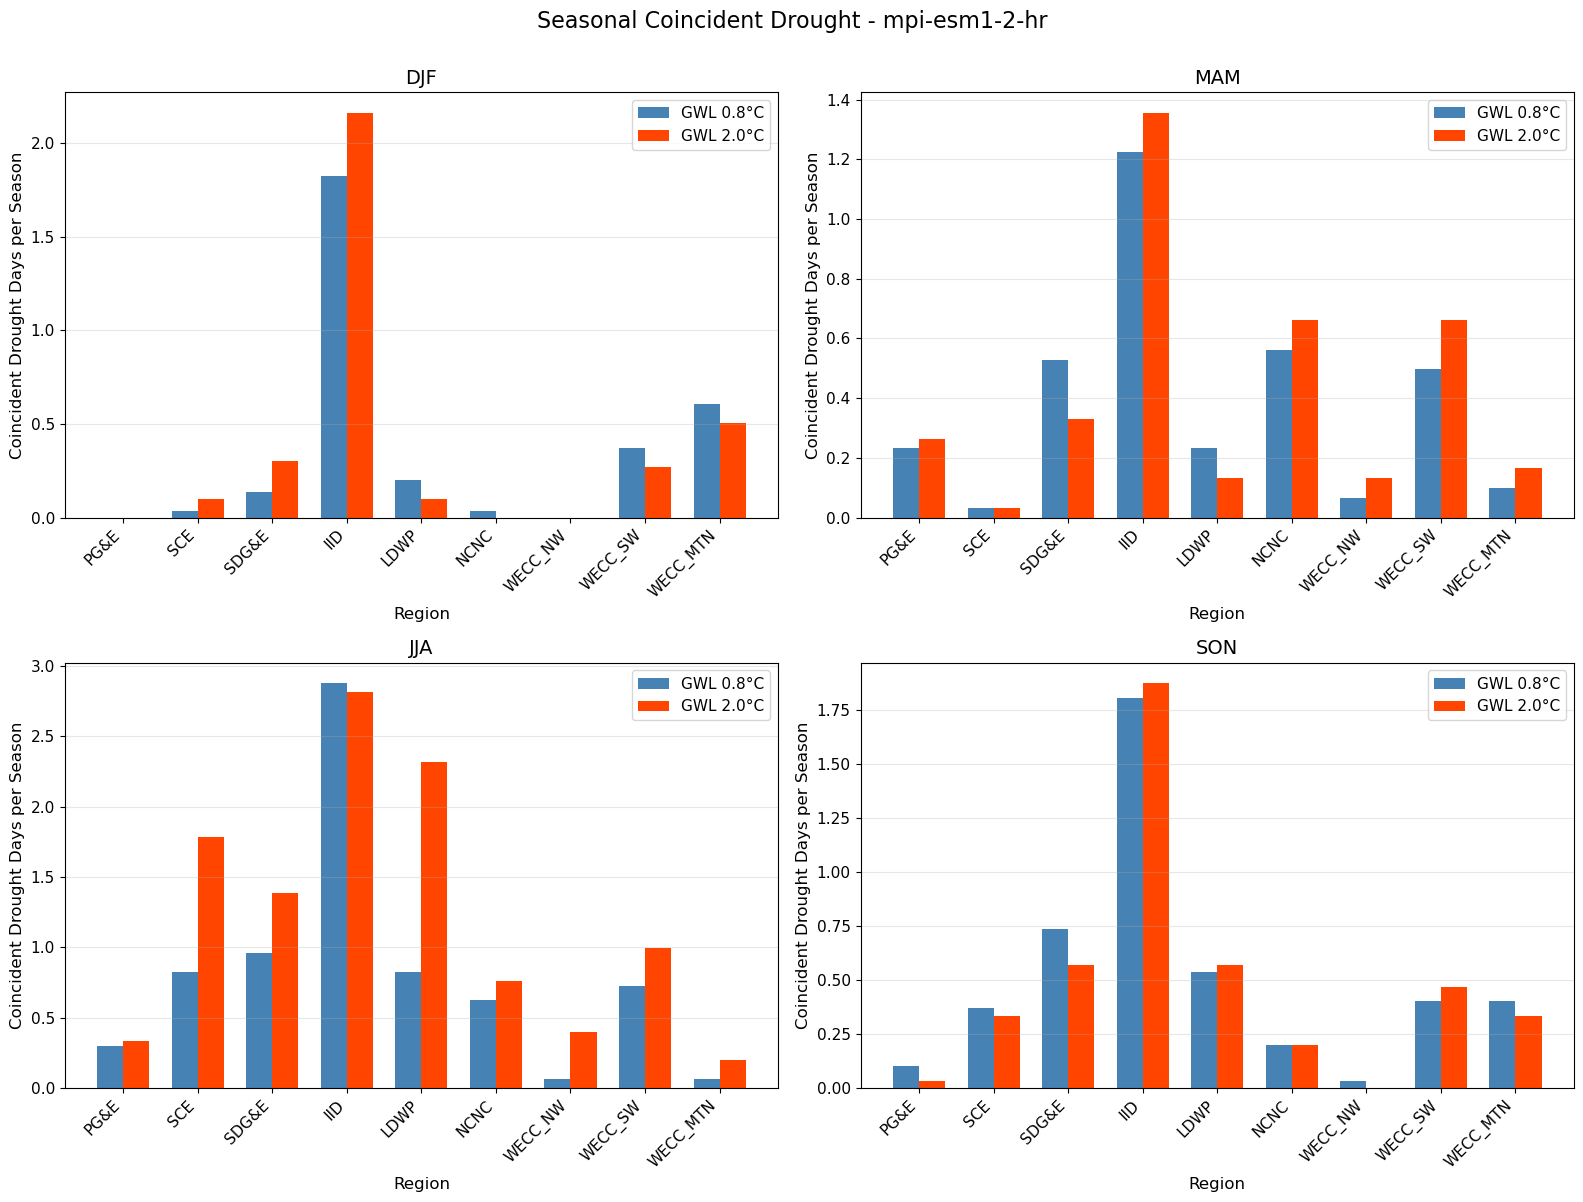

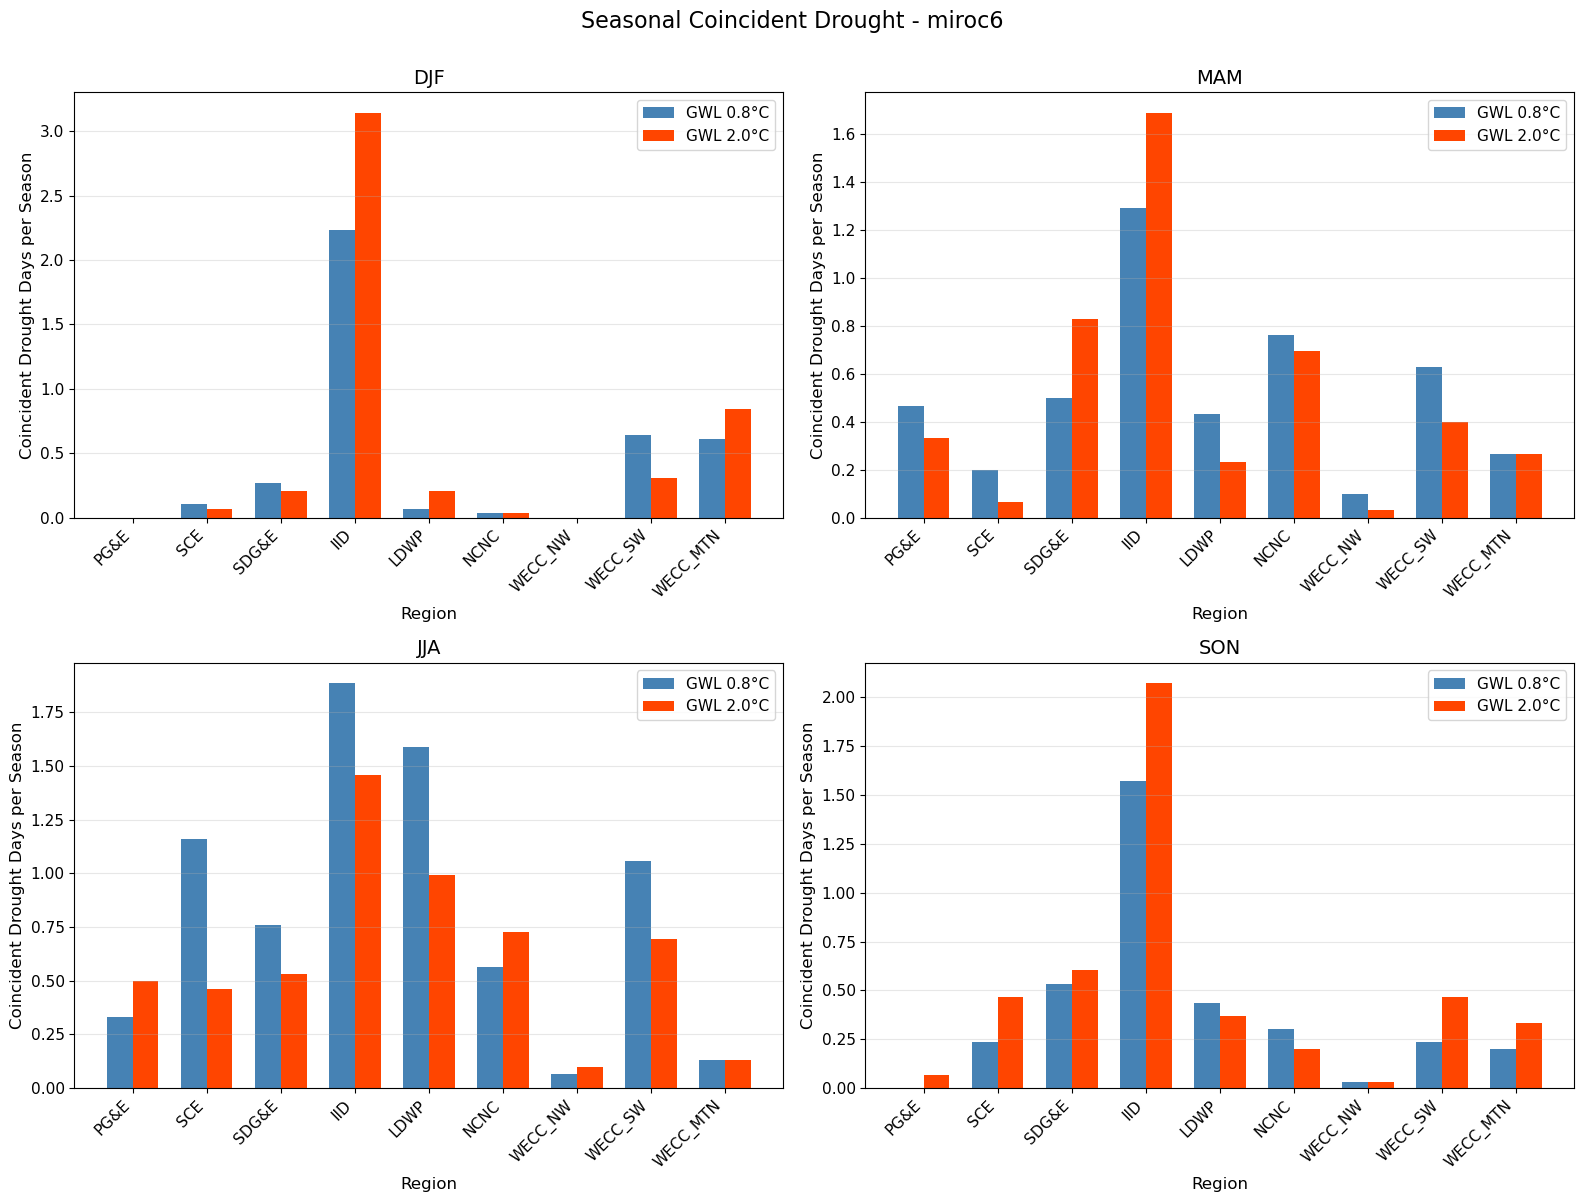

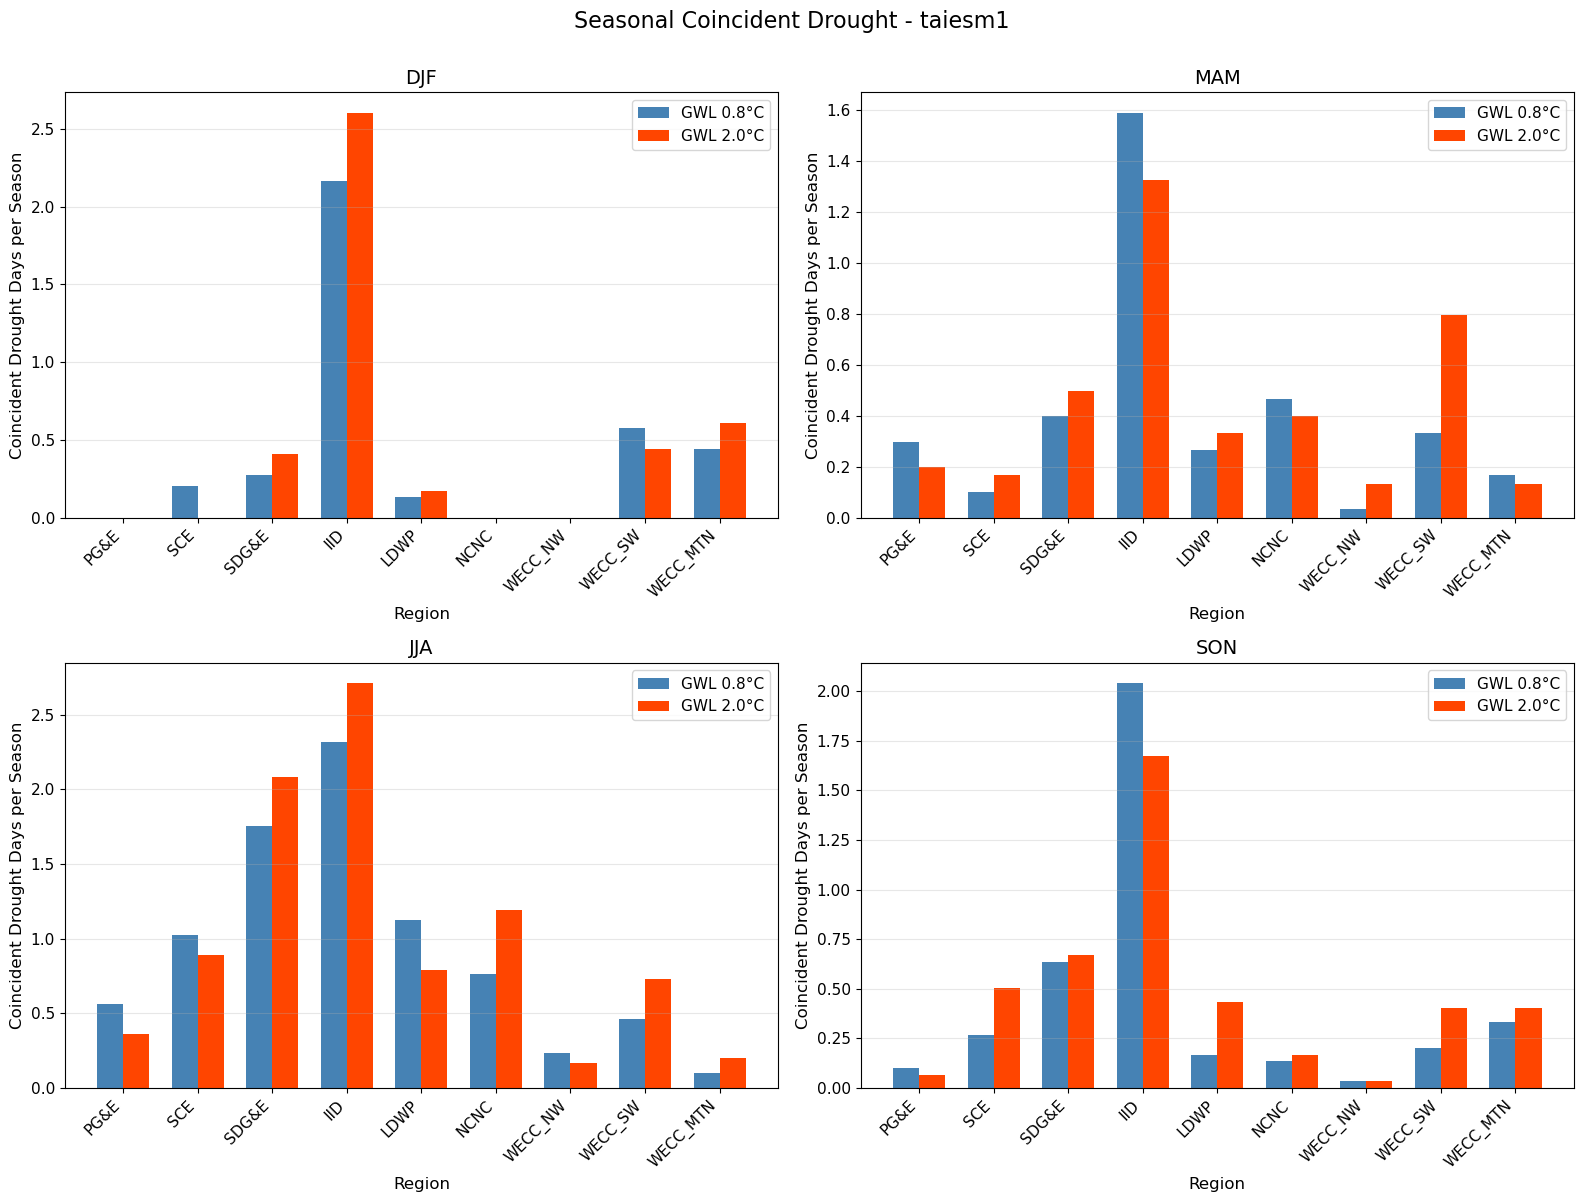

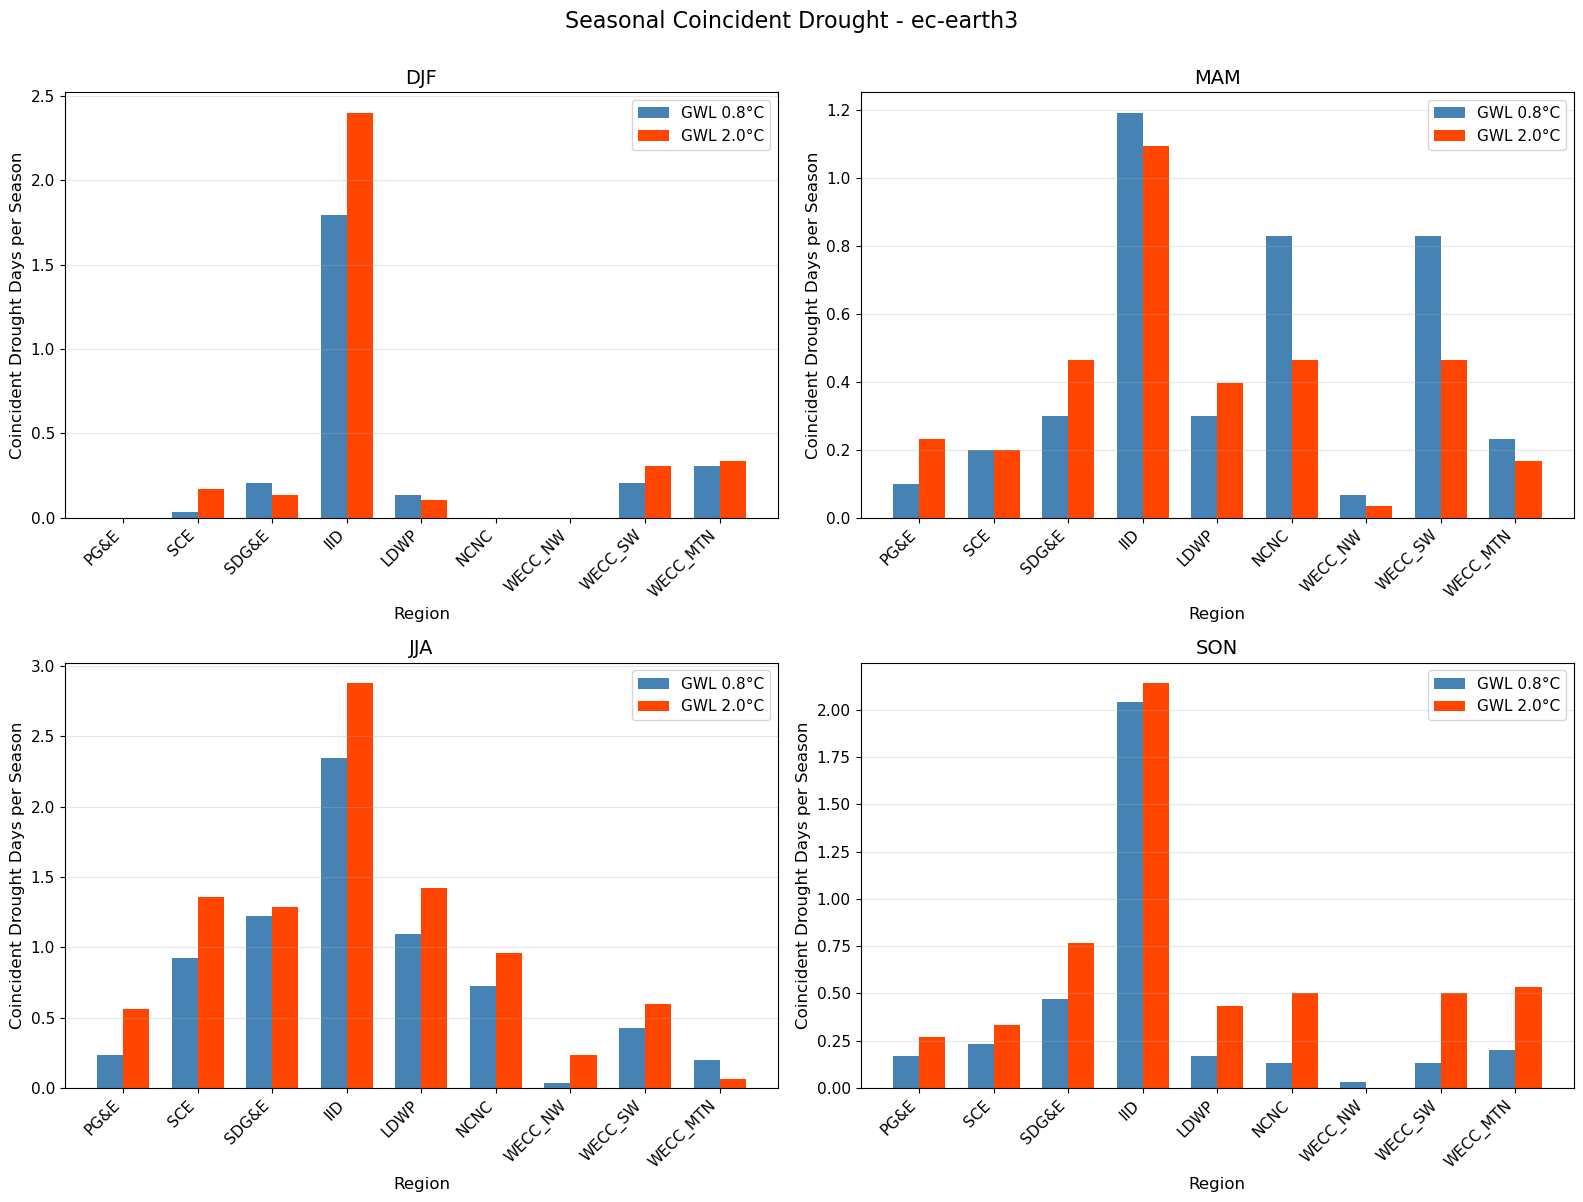

In [9]:
# Bar chart: Seasonal comparison for coincident drought
for sim in simulations:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    for idx, season in enumerate(seasons):
        ax = axes[idx]
        
        # Filter data for this simulation and season
        sim_season_data = df[(df['simulation'] == sim) & (df['season'] == season)]
        
        # Prepare data for grouped bar chart
        x = np.arange(len(utility_regions))
        width = 0.35
        
        gwl08_data = sim_season_data[sim_season_data['gwl'] == 0.8].set_index('region')['coincident_days_per_season']
        gwl20_data = sim_season_data[sim_season_data['gwl'] == 2.0].set_index('region')['coincident_days_per_season']
        
        # Ensure regions are in same order
        gwl08_values = [gwl08_data.loc[r] for r in utility_regions]
        gwl20_values = [gwl20_data.loc[r] for r in utility_regions]
        
        # Create bars
        bars1 = ax.bar(x - width/2, gwl08_values, width, label='GWL 0.8°C', color='steelblue')
        bars2 = ax.bar(x + width/2, gwl20_values, width, label='GWL 2.0°C', color='orangered')
        
        # Formatting
        ax.set_xlabel('Region')
        ax.set_ylabel('Coincident Drought Days per Season')
        ax.set_title(f'{season}')
        ax.set_xticks(x)
        ax.set_xticklabels(utility_regions, rotation=45, ha='right')
        ax.legend()
        ax.grid(axis='y', alpha=0.3)
    
    fig.suptitle(f'Seasonal Coincident Drought - {sim}', fontsize=16, y=1.00)
    plt.tight_layout()
    plt.savefig(f'seasonal_coincident_drought_{sim}.png', dpi=300, bbox_inches='tight')
    plt.show()

## Figure 2: Stacked Bar Charts - Seasonal Drought Type Breakdown

Show PV-only, wind-only, and coincident drought days for each region by season.

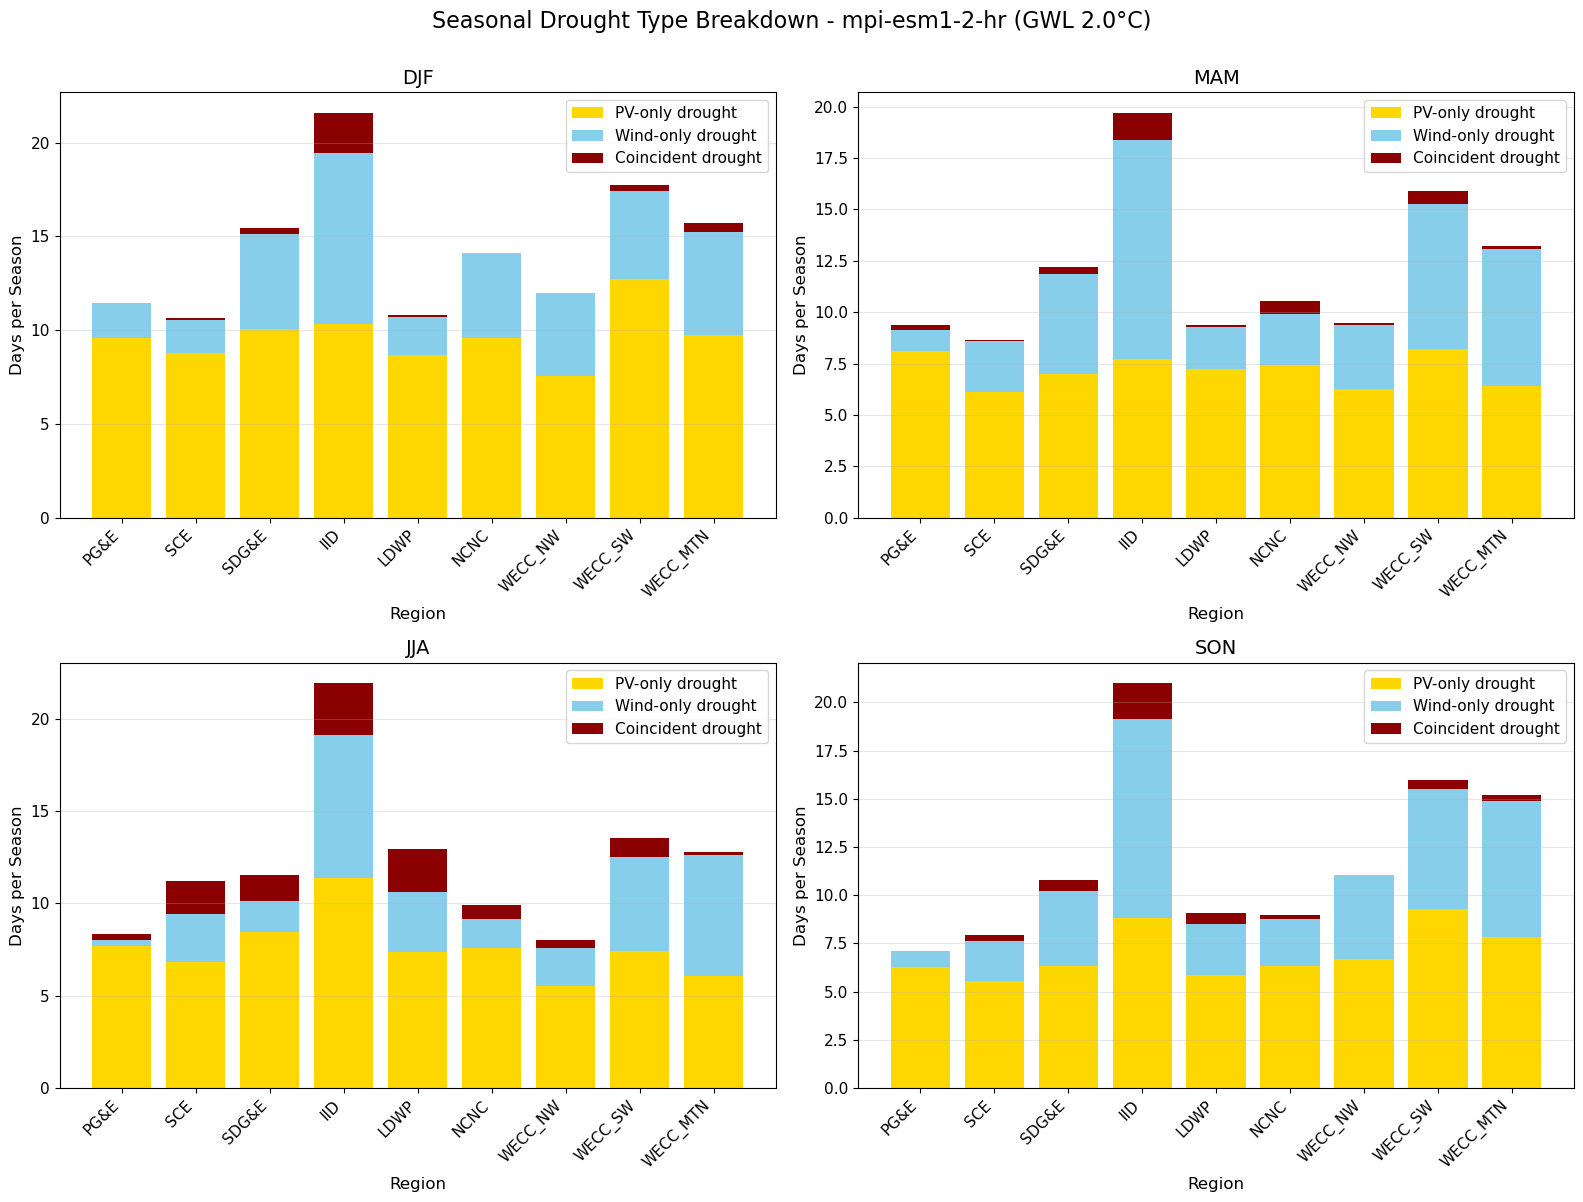

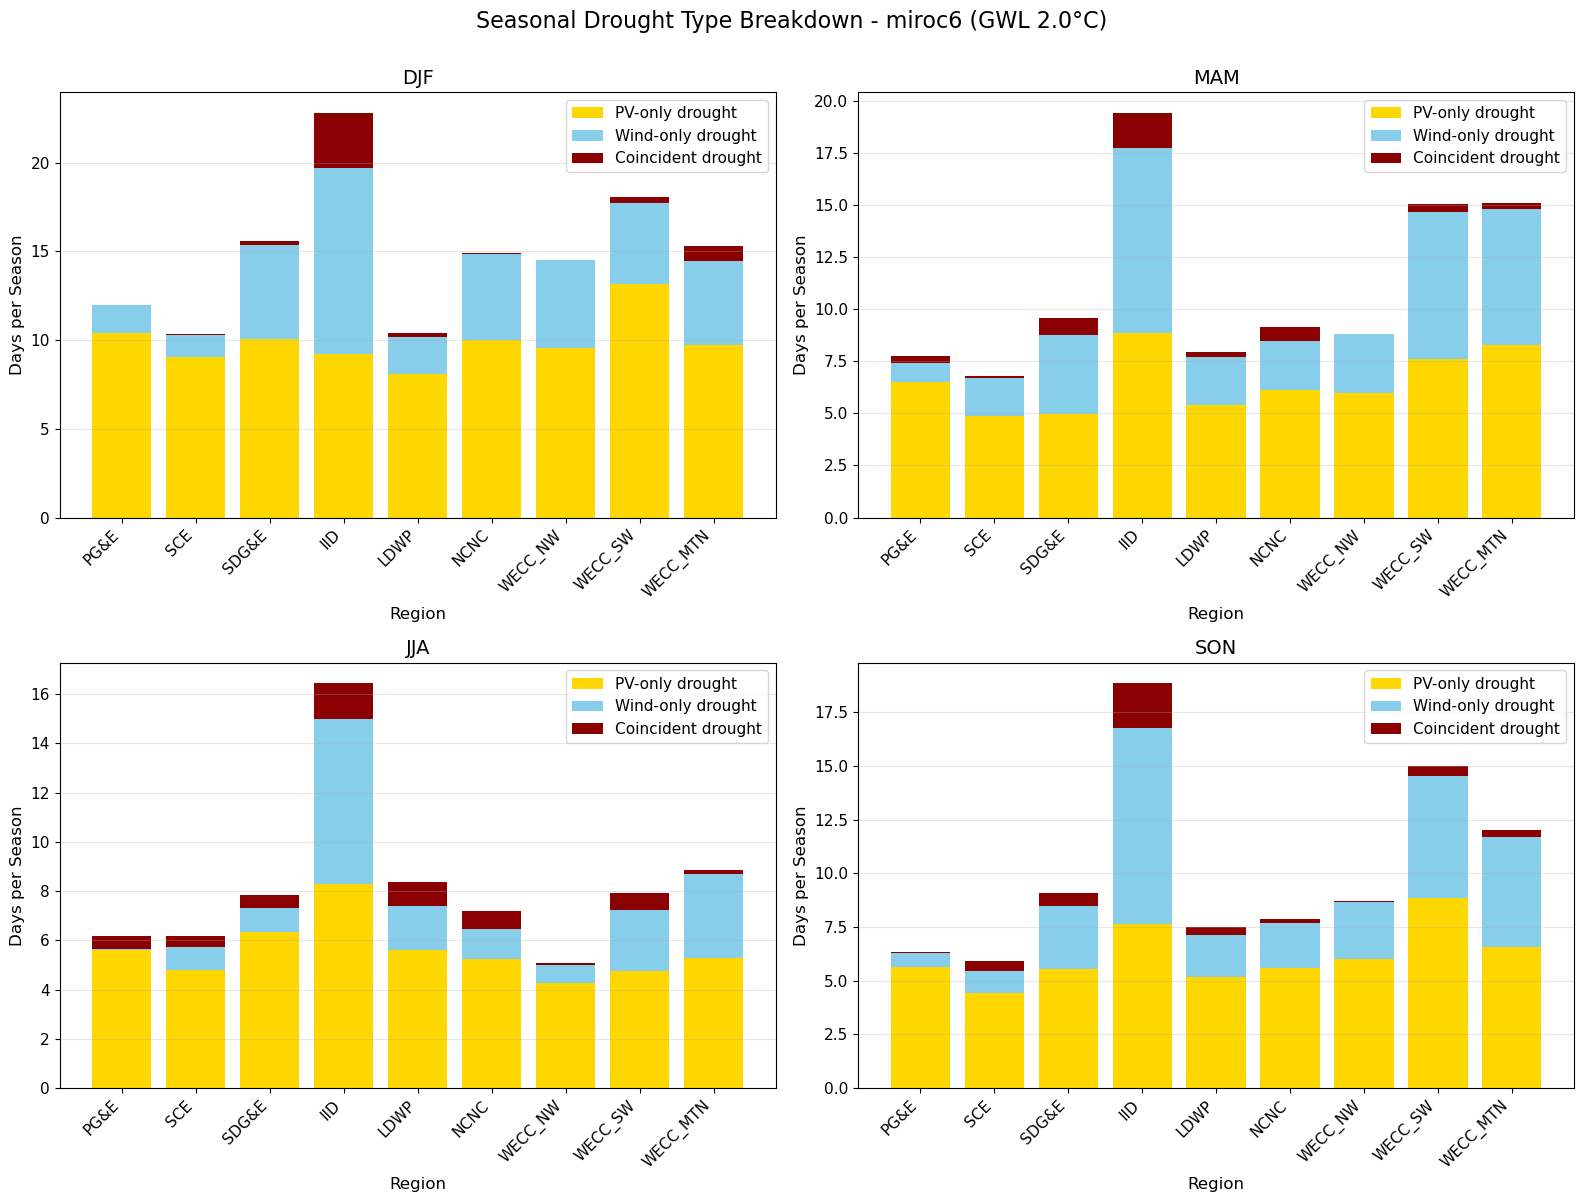

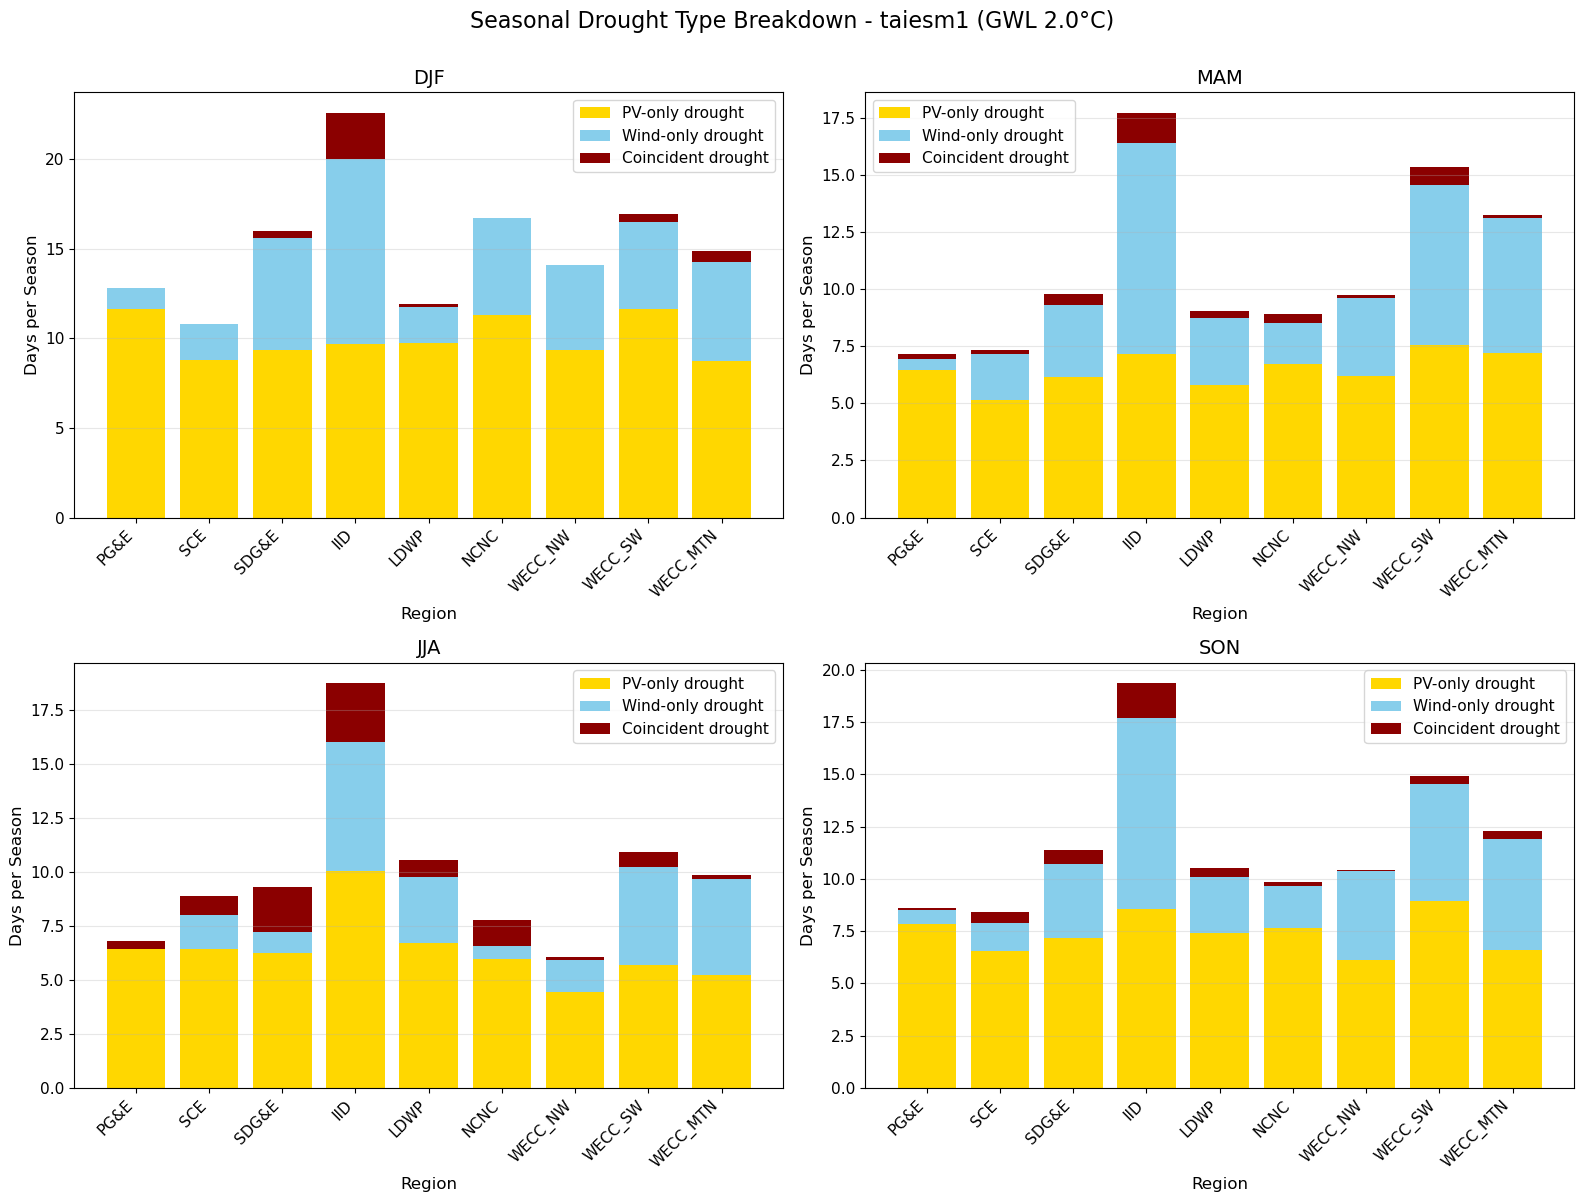

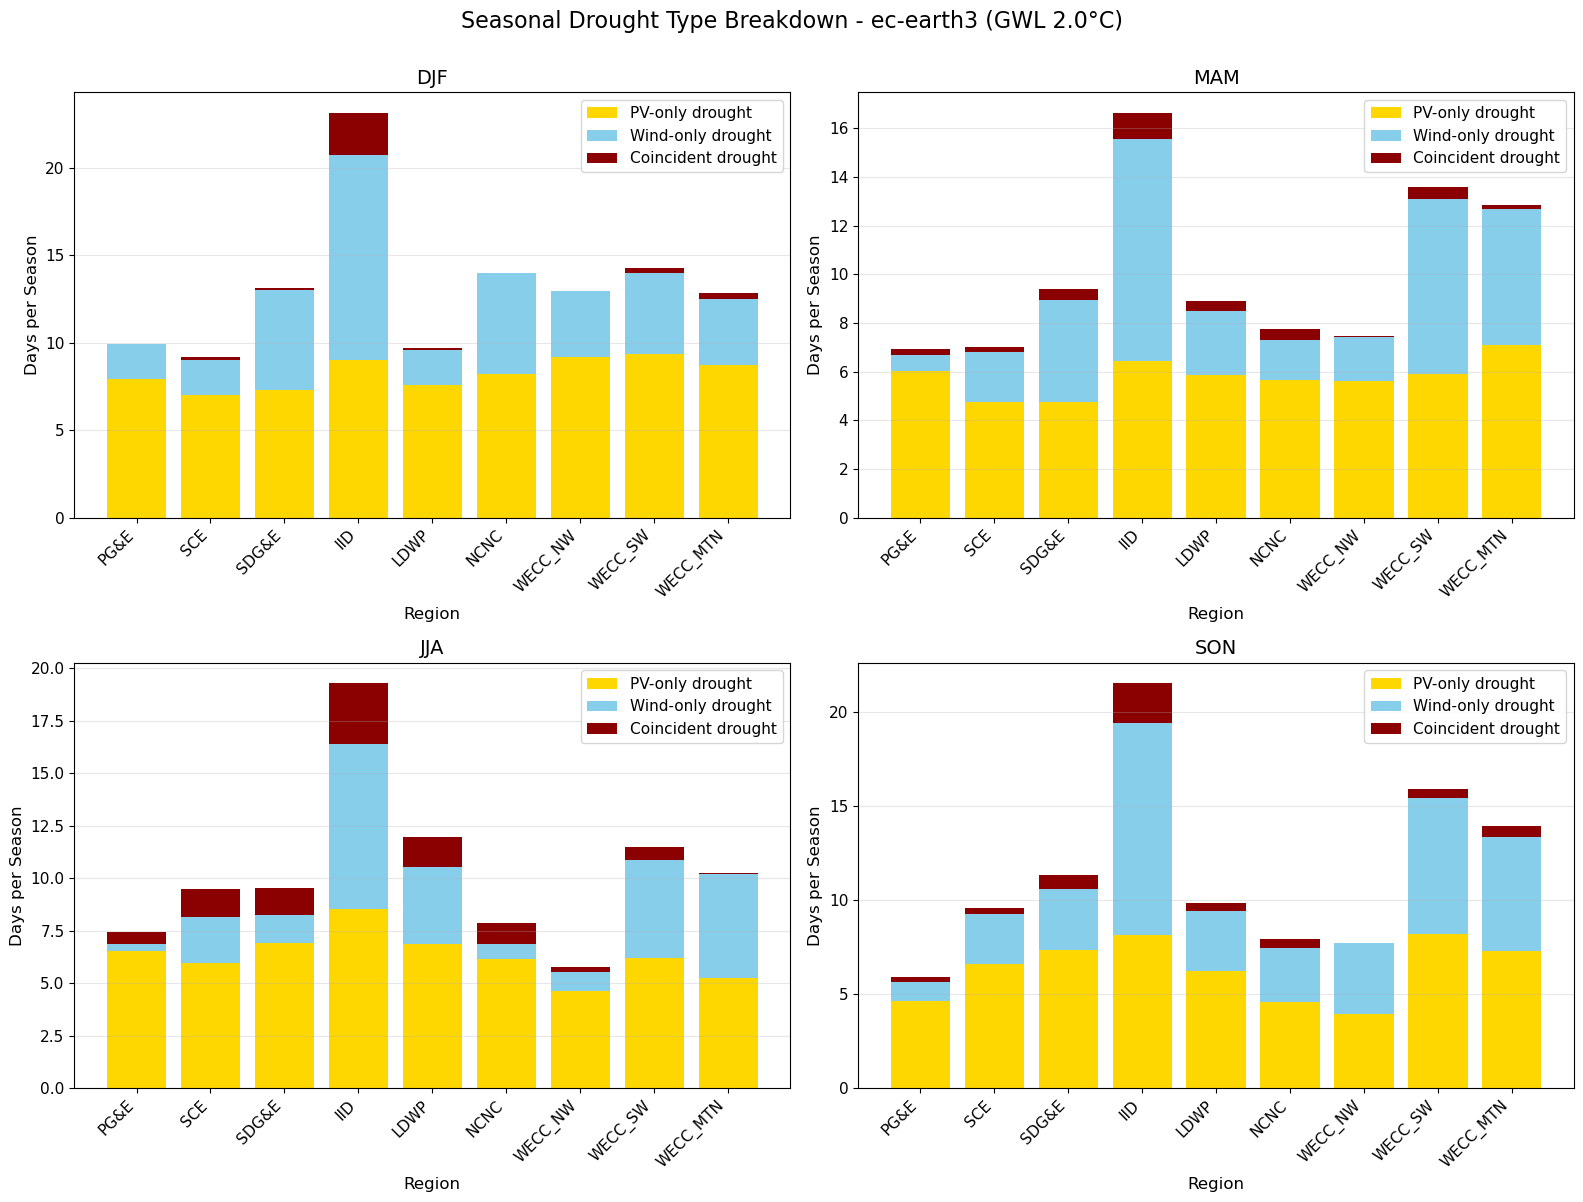

In [10]:
# Stacked bar chart showing seasonal drought type breakdown
# One figure per model, with season panels

for sim in simulations:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    for idx, season in enumerate(seasons):
        ax = axes[idx]
        
        # Filter data for this model, season, and GWL 2.0
        data = df[(df['simulation'] == sim) & (df['season'] == season) & (df['gwl'] == 2.0)].set_index('region')
        
        # Stack components
        x = np.arange(len(utility_regions))
        pv_only = [data.loc[r, 'pv_only_days_per_season'] for r in utility_regions]
        wind_only = [data.loc[r, 'wind_only_days_per_season'] for r in utility_regions]
        coincident = [data.loc[r, 'coincident_days_per_season'] for r in utility_regions]
        
        # Create stacked bars
        ax.bar(x, pv_only, label='PV-only drought', color='gold')
        ax.bar(x, wind_only, bottom=pv_only, label='Wind-only drought', color='skyblue')
        ax.bar(x, coincident, bottom=np.array(pv_only) + np.array(wind_only), 
               label='Coincident drought', color='darkred')
        
        # Formatting
        ax.set_xlabel('Region')
        ax.set_ylabel('Days per Season')
        ax.set_title(f'{season}')
        ax.set_xticks(x)
        ax.set_xticklabels(utility_regions, rotation=45, ha='right')
        ax.legend()
        ax.grid(axis='y', alpha=0.3)
    
    fig.suptitle(f'Seasonal Drought Type Breakdown - {sim} (GWL 2.0°C)', fontsize=16, y=1.00)
    plt.tight_layout()
    plt.savefig(f'seasonal_drought_breakdown_{sim}.png', dpi=300, bbox_inches='tight')
    plt.show()

## Figure 3: Multi-Model Mean by Season

Show ensemble mean with seasonal breakdown.

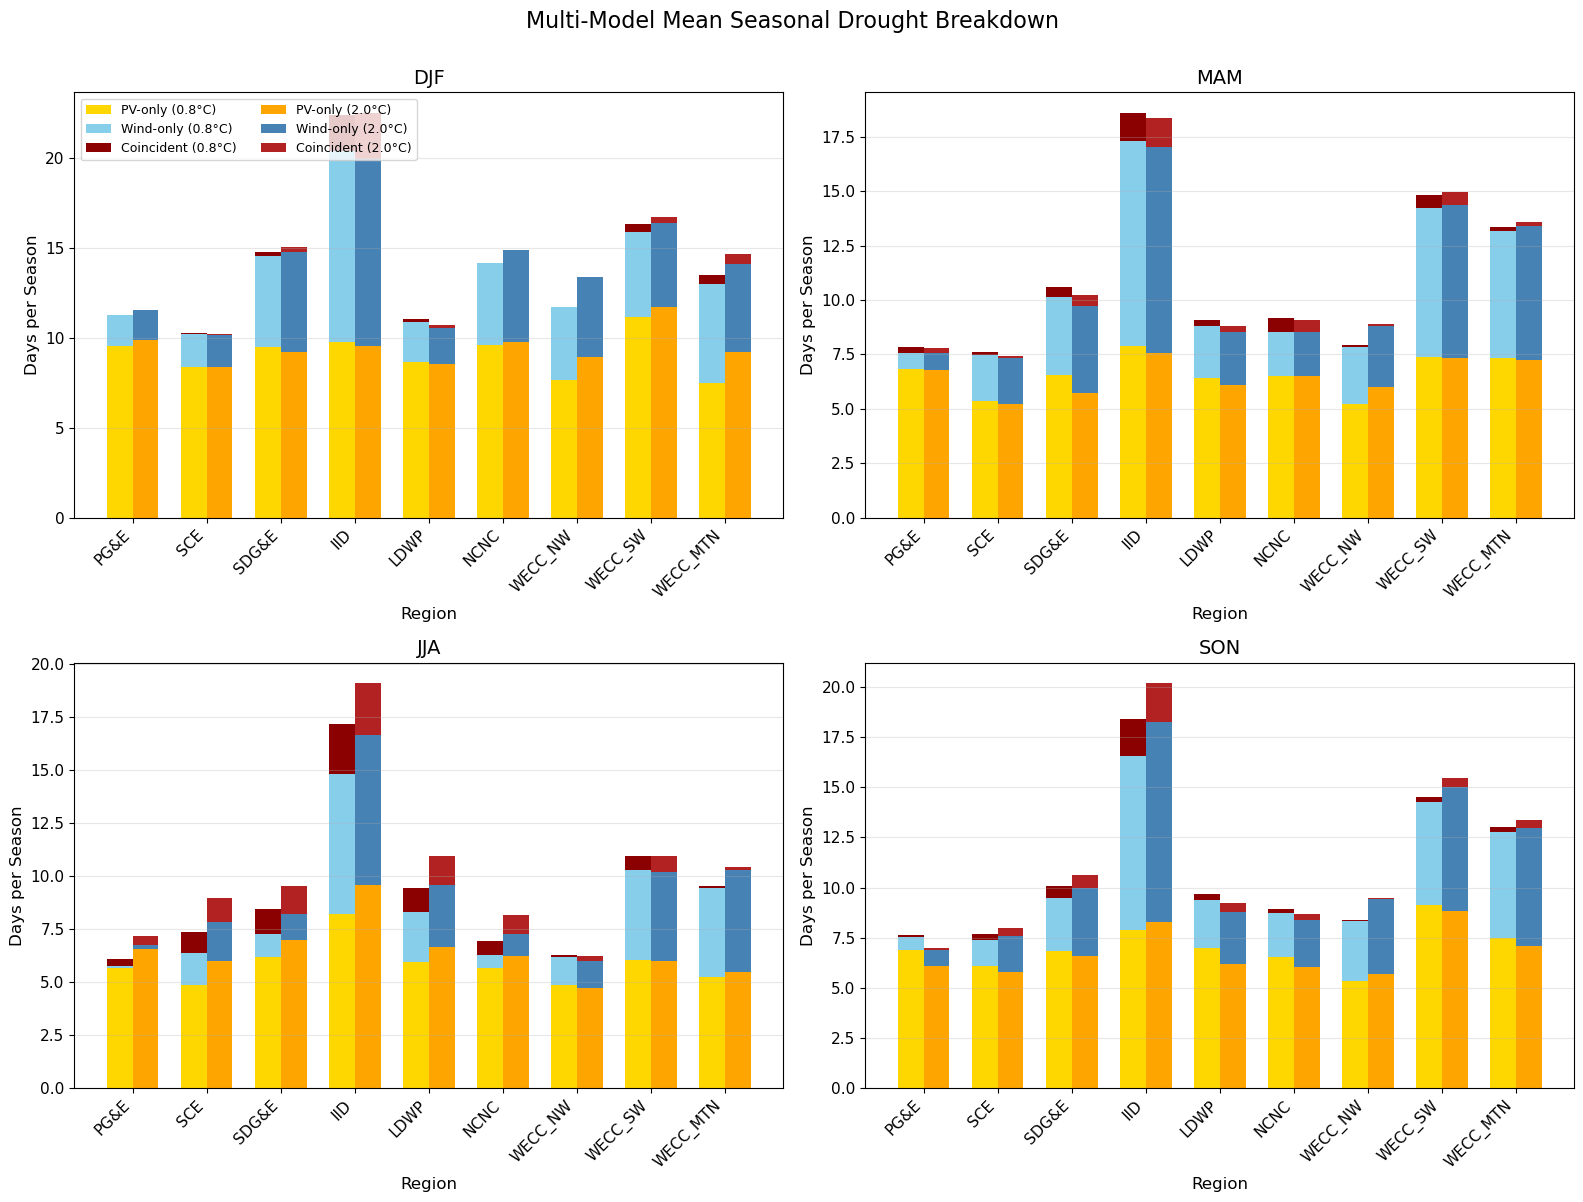

In [11]:
# Calculate multi-model mean for each region, season, and GWL
ensemble_data = df.groupby(['region', 'season', 'gwl']).agg({
    'pv_only_days_per_season': 'mean',
    'wind_only_days_per_season': 'mean',
    'coincident_days_per_season': 'mean',
    'no_drought_days_per_season': 'mean'
}).reset_index()

# Create figure with 4 season panels
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, season in enumerate(seasons):
    ax = axes[idx]
    
    x = np.arange(len(utility_regions))
    width = 0.35
    
    for gwl_idx, gwl in enumerate(target_gwls):
        season_gwl_data = ensemble_data[(ensemble_data['season'] == season) & (ensemble_data['gwl'] == gwl)].set_index('region')
        
        # Get values in correct order
        pv_only = [season_gwl_data.loc[r, 'pv_only_days_per_season'] for r in utility_regions]
        wind_only = [season_gwl_data.loc[r, 'wind_only_days_per_season'] for r in utility_regions]
        coincident = [season_gwl_data.loc[r, 'coincident_days_per_season'] for r in utility_regions]
        
        # Position for this GWL's bars
        pos = x + (gwl_idx - 0.5) * width
        
        # Color scheme
        if gwl == 0.8:
            pv_color = 'gold'
            wind_color = 'skyblue'
            coin_color = 'darkred'
            label_suffix = ' (0.8°C)'
        else:
            pv_color = 'orange'
            wind_color = 'steelblue'
            coin_color = 'firebrick'
            label_suffix = ' (2.0°C)'
        
        # Create stacked bars (only add labels in first subplot)
        if idx == 0:
            ax.bar(pos, pv_only, width, label=f'PV-only{label_suffix}', color=pv_color)
            ax.bar(pos, wind_only, width, bottom=pv_only, 
                   label=f'Wind-only{label_suffix}', color=wind_color)
            ax.bar(pos, coincident, width, bottom=np.array(pv_only) + np.array(wind_only), 
                   label=f'Coincident{label_suffix}', color=coin_color)
        else:
            ax.bar(pos, pv_only, width, color=pv_color)
            ax.bar(pos, wind_only, width, bottom=pv_only, color=wind_color)
            ax.bar(pos, coincident, width, bottom=np.array(pv_only) + np.array(wind_only), 
                   color=coin_color)
    
    # Formatting
    ax.set_xlabel('Region')
    ax.set_ylabel('Days per Season')
    ax.set_title(f'{season}')
    ax.set_xticks(x)
    ax.set_xticklabels(utility_regions, rotation=45, ha='right')
    if idx == 0:
        ax.legend(ncol=2, loc='upper left', fontsize=9)
    ax.grid(axis='y', alpha=0.3)

fig.suptitle('Multi-Model Mean Seasonal Drought Breakdown', fontsize=16, y=1.00)
plt.tight_layout()
plt.savefig('seasonal_drought_multimodel_mean.png', dpi=300, bbox_inches='tight')
plt.show()

## Figure 4: Seasonal Heatmaps - Coincident Drought

Show seasonal patterns of coincident drought frequency.

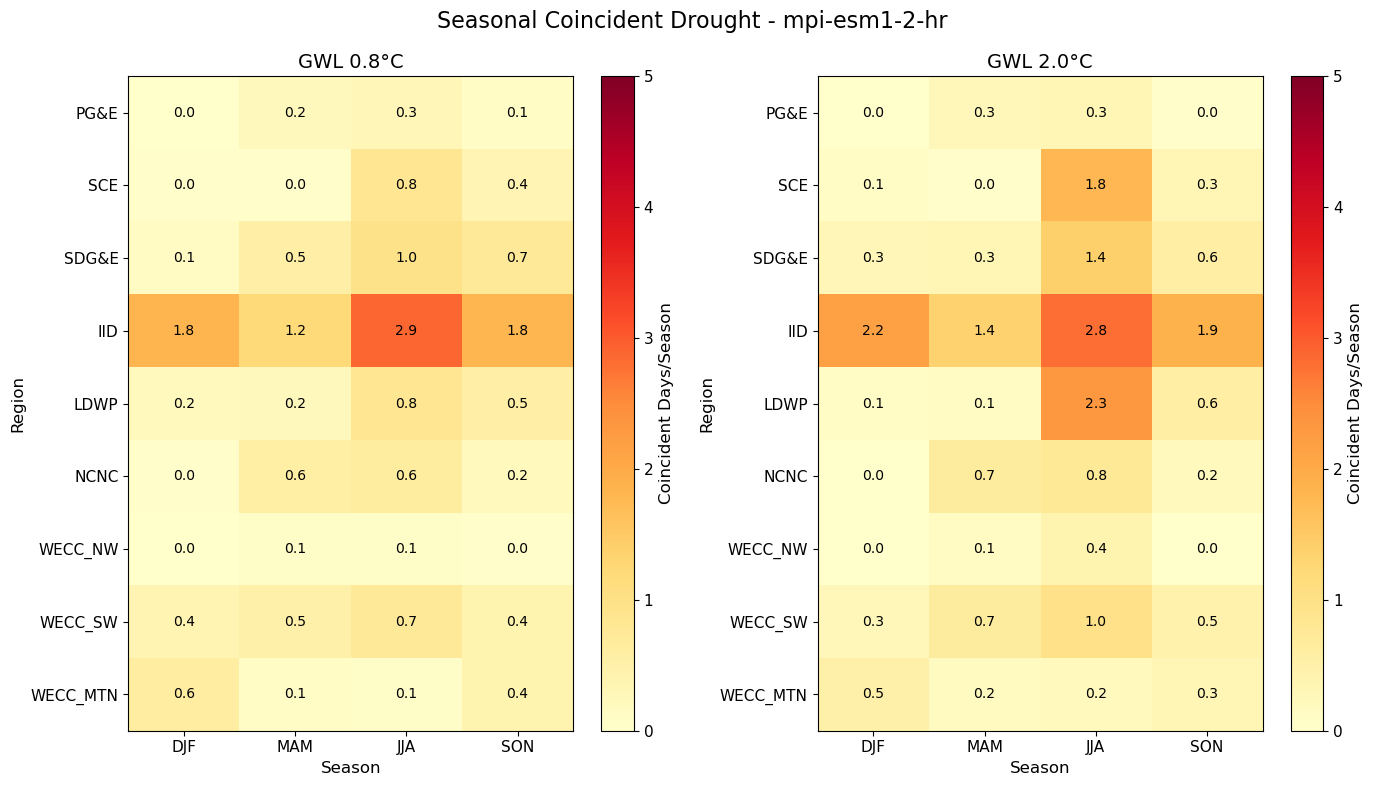

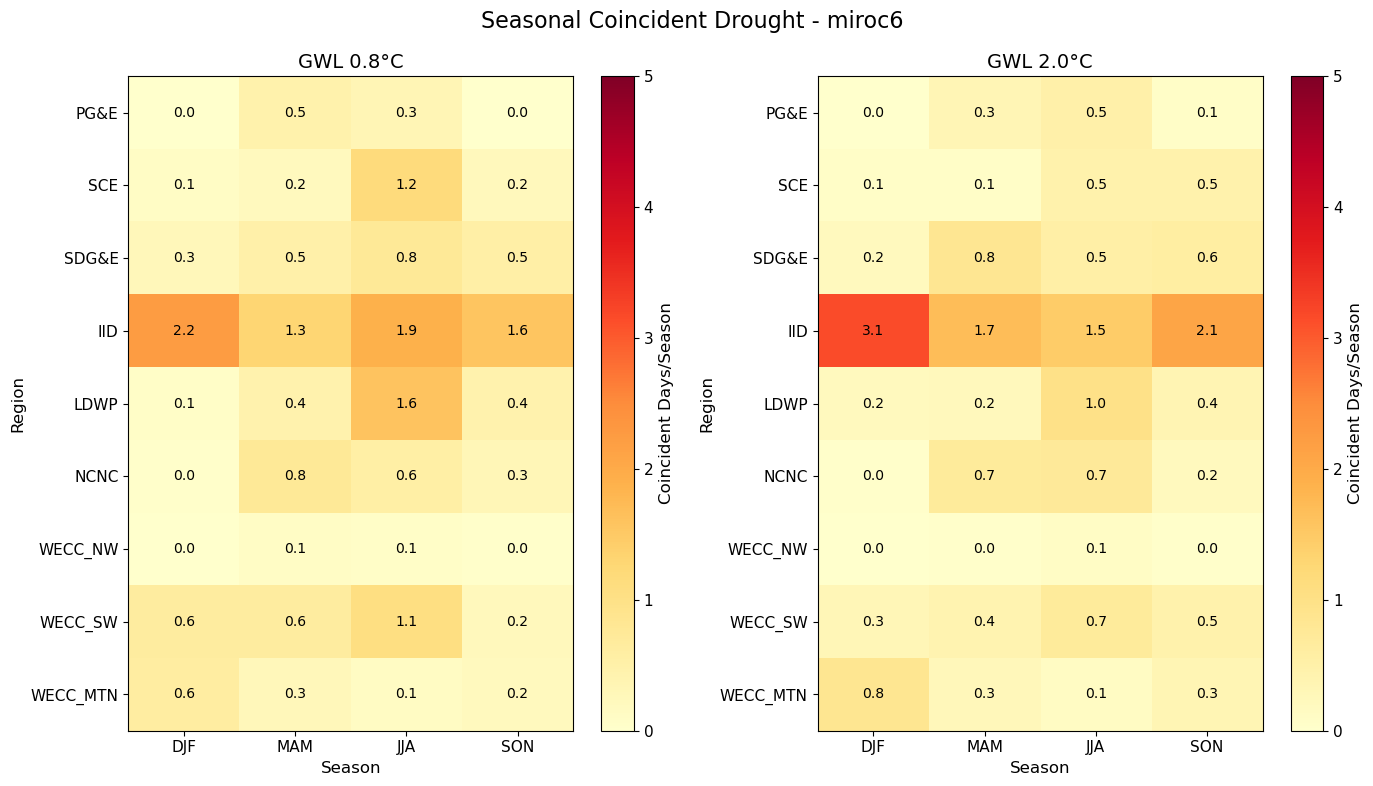

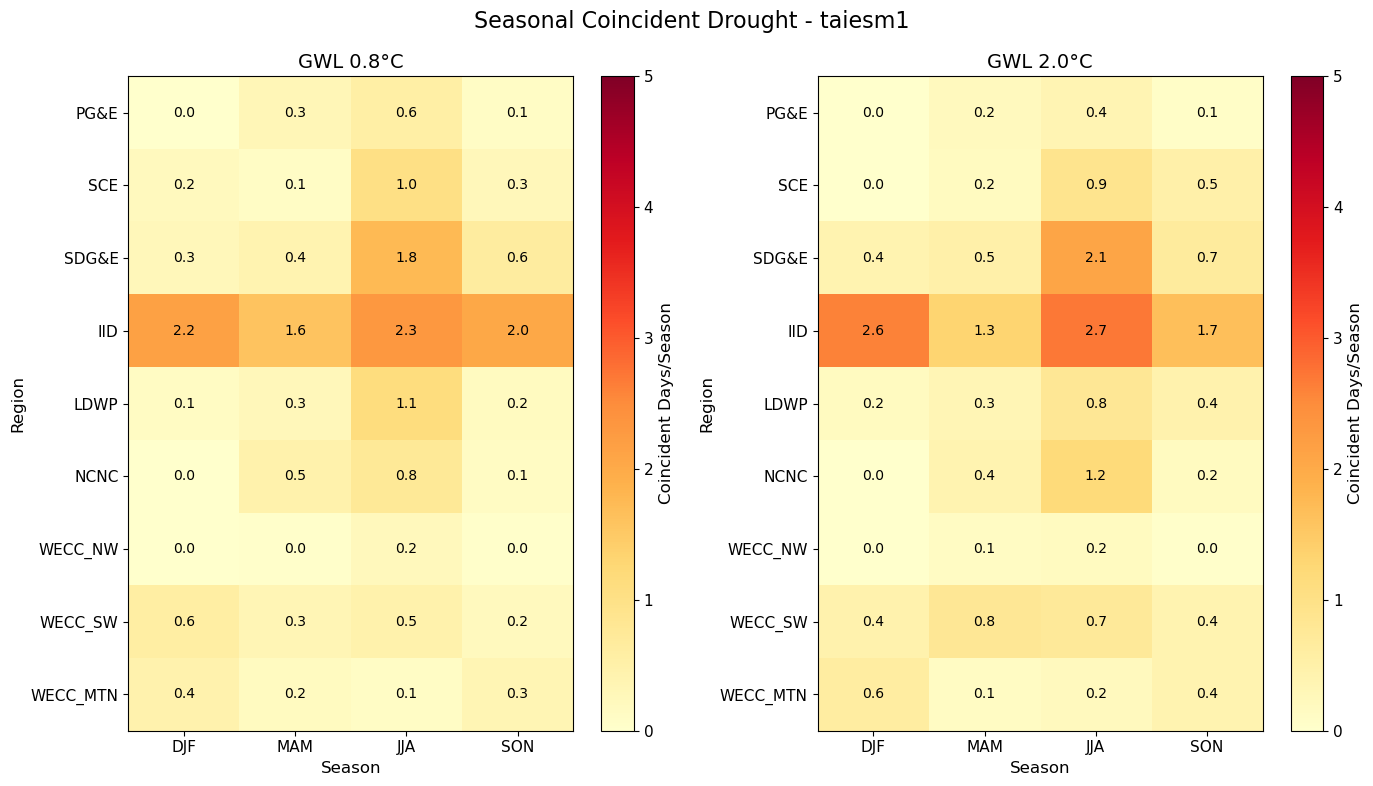

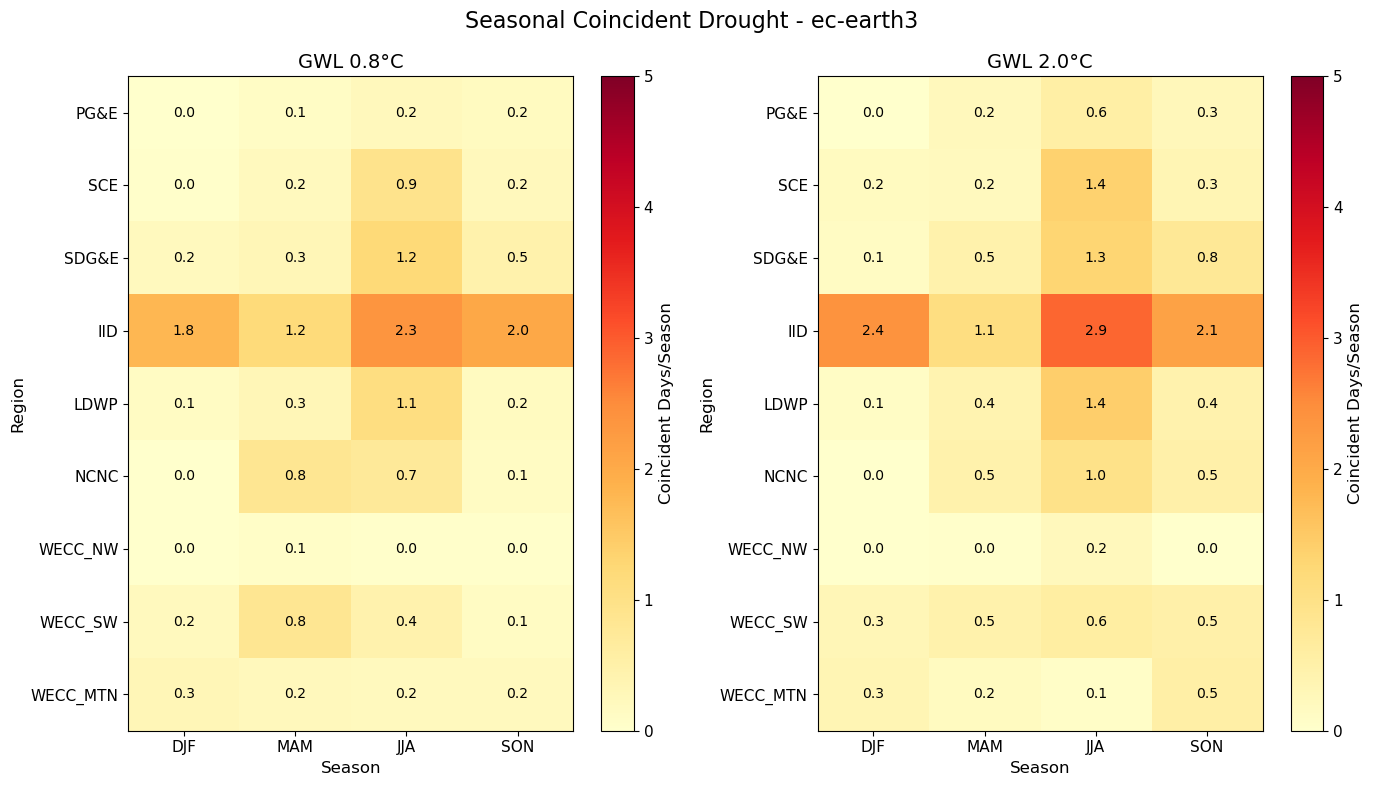

In [12]:
# Heatmap: regions (rows) x seasons (columns) for each model and GWL
for sim in simulations:
    fig, axes = plt.subplots(1, 2, figsize=(14, 8))
    
    for idx, gwl in enumerate(target_gwls):
        ax = axes[idx]
        
        # Pivot data to create matrix: regions x seasons
        data = df[(df['gwl'] == gwl) & (df['simulation'] == sim)].pivot(
            index='region', 
            columns='season', 
            values='coincident_days_per_season'
        )
        
        # Reorder to match utility_regions and seasons lists
        data = data.reindex(utility_regions)
        data = data[seasons]  # Reorder columns to match season order
        
        # Create heatmap
        im = ax.imshow(data.values, cmap='YlOrRd', aspect='auto', vmin=0, vmax=5)
        
        # Set ticks and labels
        ax.set_xticks(np.arange(len(seasons)))
        ax.set_yticks(np.arange(len(utility_regions)))
        ax.set_xticklabels(seasons)
        ax.set_yticklabels(utility_regions)
        
        # Add values as text
        for i in range(len(utility_regions)):
            for j in range(len(seasons)):
                text = ax.text(j, i, f'{data.values[i, j]:.1f}',
                              ha="center", va="center", color="black", fontsize=10)
        
        ax.set_title(f'GWL {gwl}°C')
        ax.set_xlabel('Season')
        ax.set_ylabel('Region')
        
        # Add colorbar
        cbar = plt.colorbar(im, ax=ax)
        cbar.set_label('Coincident Days/Season')
    
    fig.suptitle(f'Seasonal Coincident Drought - {sim}', fontsize=16, y=0.98)
    plt.tight_layout()
    plt.savefig(f'seasonal_heatmap_{sim}.png', dpi=300, bbox_inches='tight')
    plt.show()

## Figure 5: Time Series - Seasonal Pattern Across Years

Show how seasonal patterns vary within each GWL period.

AttributeError: 'DataArrayGroupBy' object has no attribute 'resample'

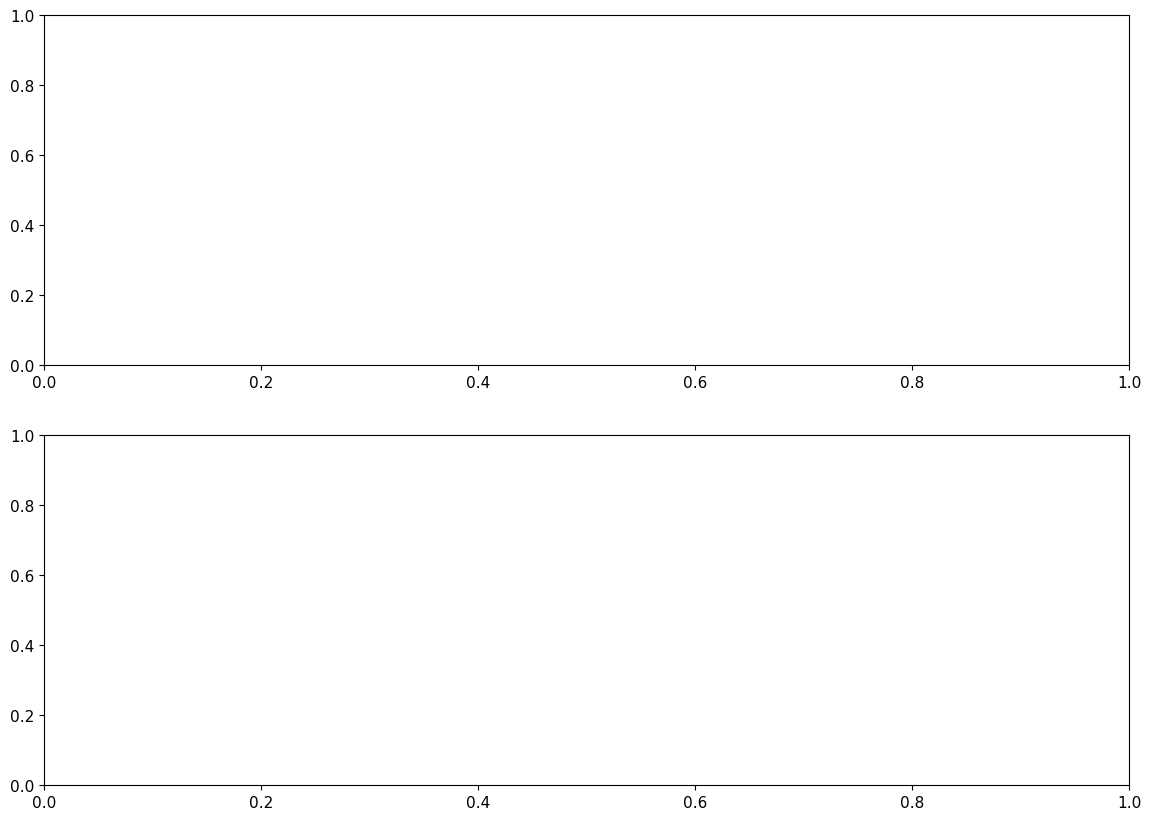

In [13]:
# Time series of seasonal coincident drought for selected region
selected_region = "PG&E"
selected_sim = "mpi-esm1-2-hr"

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

for idx, gwl in enumerate(target_gwls):
    ax = axes[idx]
    
    # Get data for this region and simulation
    pv_data = drought_data[gwl][selected_sim][selected_region]['pv']
    wind_data = drought_data[gwl][selected_sim][selected_region]['wind']
    
    # Create masks
    pv_mask = (pv_data > drought_threshold).astype(int)
    wind_mask = (wind_data > drought_threshold).astype(int)
    coincident_mask = (pv_mask == 1) & (wind_mask == 1)
    
    # Group by season and year, then count
    coincident_seasonal = coincident_mask.groupby('time.season').resample(time='YE').sum()
    
    # Plot each season
    for season in seasons:
        if season in coincident_seasonal.groups:
            season_data = coincident_seasonal.sel(season=season)
            ax.plot(season_data.time.dt.year, season_data.values, 
                   marker='o', label=season, linewidth=2)
    
    ax.set_xlabel('Year')
    ax.set_ylabel('Coincident Drought Days per Season')
    ax.set_title(f'GWL {gwl}°C - {selected_region} ({selected_sim})')
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(f'seasonal_timeseries_{selected_region}_{selected_sim}.png', dpi=300, bbox_inches='tight')
plt.show()

## Figure 6: Change Between GWLs by Season

Calculate and visualize the change in coincident drought days between GWL 0.8 and 2.0 for each season.

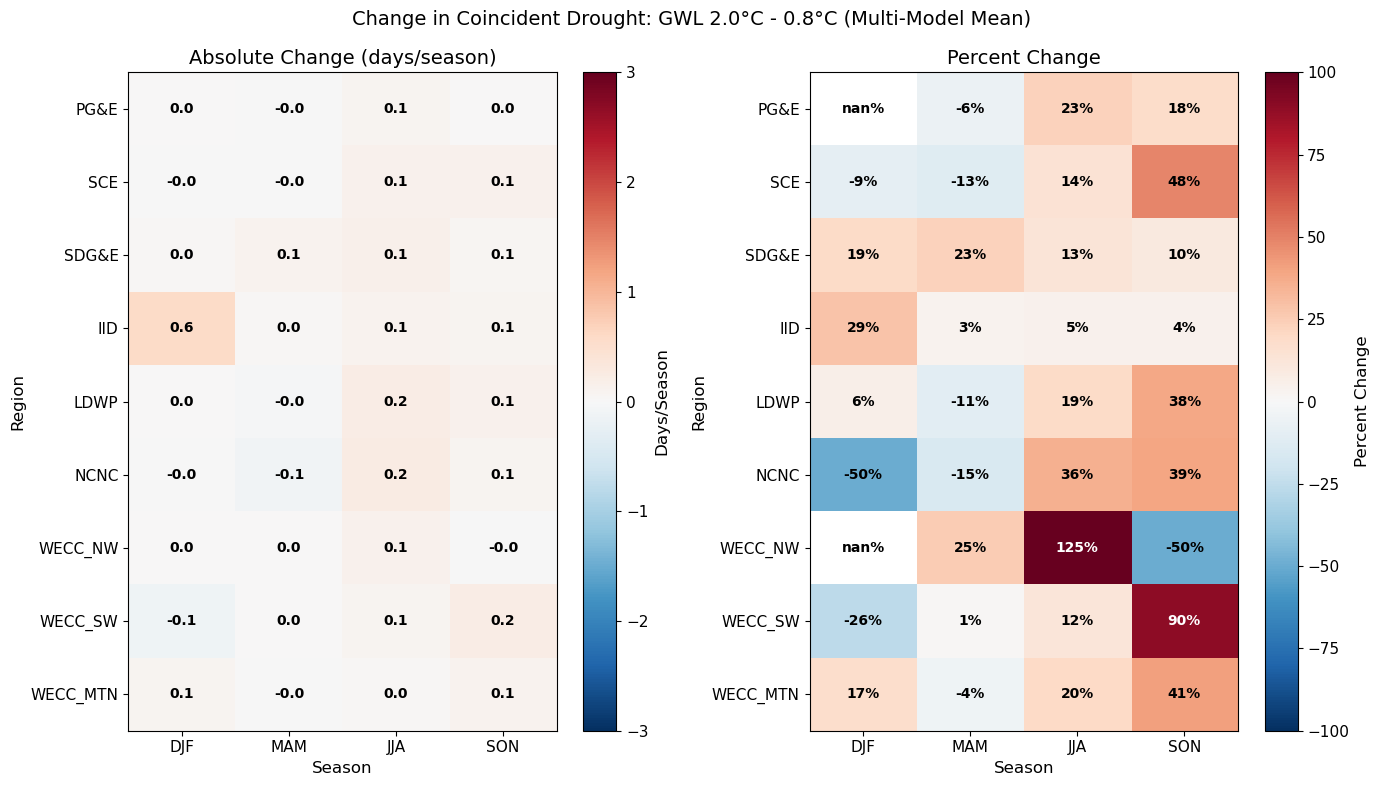

In [14]:
# Calculate change between GWLs for each season
ensemble_change = ensemble_data.pivot_table(
    index=['region', 'season'],
    columns='gwl',
    values='coincident_days_per_season'
).reset_index()

ensemble_change['change'] = ensemble_change[2.0] - ensemble_change[0.8]
ensemble_change['pct_change'] = (ensemble_change['change'] / ensemble_change[0.8]) * 100

# Create heatmap of changes
fig, axes = plt.subplots(1, 2, figsize=(14, 8))

# Absolute change
ax = axes[0]
pivot_abs = ensemble_change.pivot(index='region', columns='season', values='change')
pivot_abs = pivot_abs.reindex(utility_regions)[seasons]

im1 = ax.imshow(pivot_abs.values, cmap='RdBu_r', aspect='auto', vmin=-3, vmax=3)
ax.set_xticks(np.arange(len(seasons)))
ax.set_yticks(np.arange(len(utility_regions)))
ax.set_xticklabels(seasons)
ax.set_yticklabels(utility_regions)

for i in range(len(utility_regions)):
    for j in range(len(seasons)):
        val = pivot_abs.values[i, j]
        color = 'white' if abs(val) > 1.5 else 'black'
        ax.text(j, i, f'{val:.1f}', ha="center", va="center", 
               color=color, fontsize=10, fontweight='bold')

ax.set_title('Absolute Change (days/season)')
ax.set_xlabel('Season')
ax.set_ylabel('Region')
cbar1 = plt.colorbar(im1, ax=ax)
cbar1.set_label('Days/Season')

# Percent change
ax = axes[1]
pivot_pct = ensemble_change.pivot(index='region', columns='season', values='pct_change')
pivot_pct = pivot_pct.reindex(utility_regions)[seasons]

im2 = ax.imshow(pivot_pct.values, cmap='RdBu_r', aspect='auto', vmin=-100, vmax=100)
ax.set_xticks(np.arange(len(seasons)))
ax.set_yticks(np.arange(len(utility_regions)))
ax.set_xticklabels(seasons)
ax.set_yticklabels(utility_regions)

for i in range(len(utility_regions)):
    for j in range(len(seasons)):
        val = pivot_pct.values[i, j]
        color = 'white' if abs(val) > 50 else 'black'
        ax.text(j, i, f'{val:.0f}%', ha="center", va="center", 
               color=color, fontsize=10, fontweight='bold')

ax.set_title('Percent Change')
ax.set_xlabel('Season')
ax.set_ylabel('Region')
cbar2 = plt.colorbar(im2, ax=ax)
cbar2.set_label('Percent Change')

fig.suptitle('Change in Coincident Drought: GWL 2.0°C - 0.8°C (Multi-Model Mean)', 
             fontsize=14, y=0.98)
plt.tight_layout()
plt.savefig('seasonal_change_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

## Figure 7: Choropleth Maps - Multi-Model Mean Coincident Drought by Season

Visualize spatial patterns of seasonal coincident drought frequency across California utility regions.

In [15]:
# Load shapefile
gdf = gpd.read_file(shapefile_path)
print(f"Loaded shapefile with {len(gdf)} regions")
print(f"Region names: {gdf['name'].tolist()}")

Loaded shapefile with 9 regions
Region names: ['PG&E', 'IID', 'LDWP', 'NCNC', 'SCE', 'SDG&E', 'WECC_NW', 'WECC_SW', 'WECC_MTN']


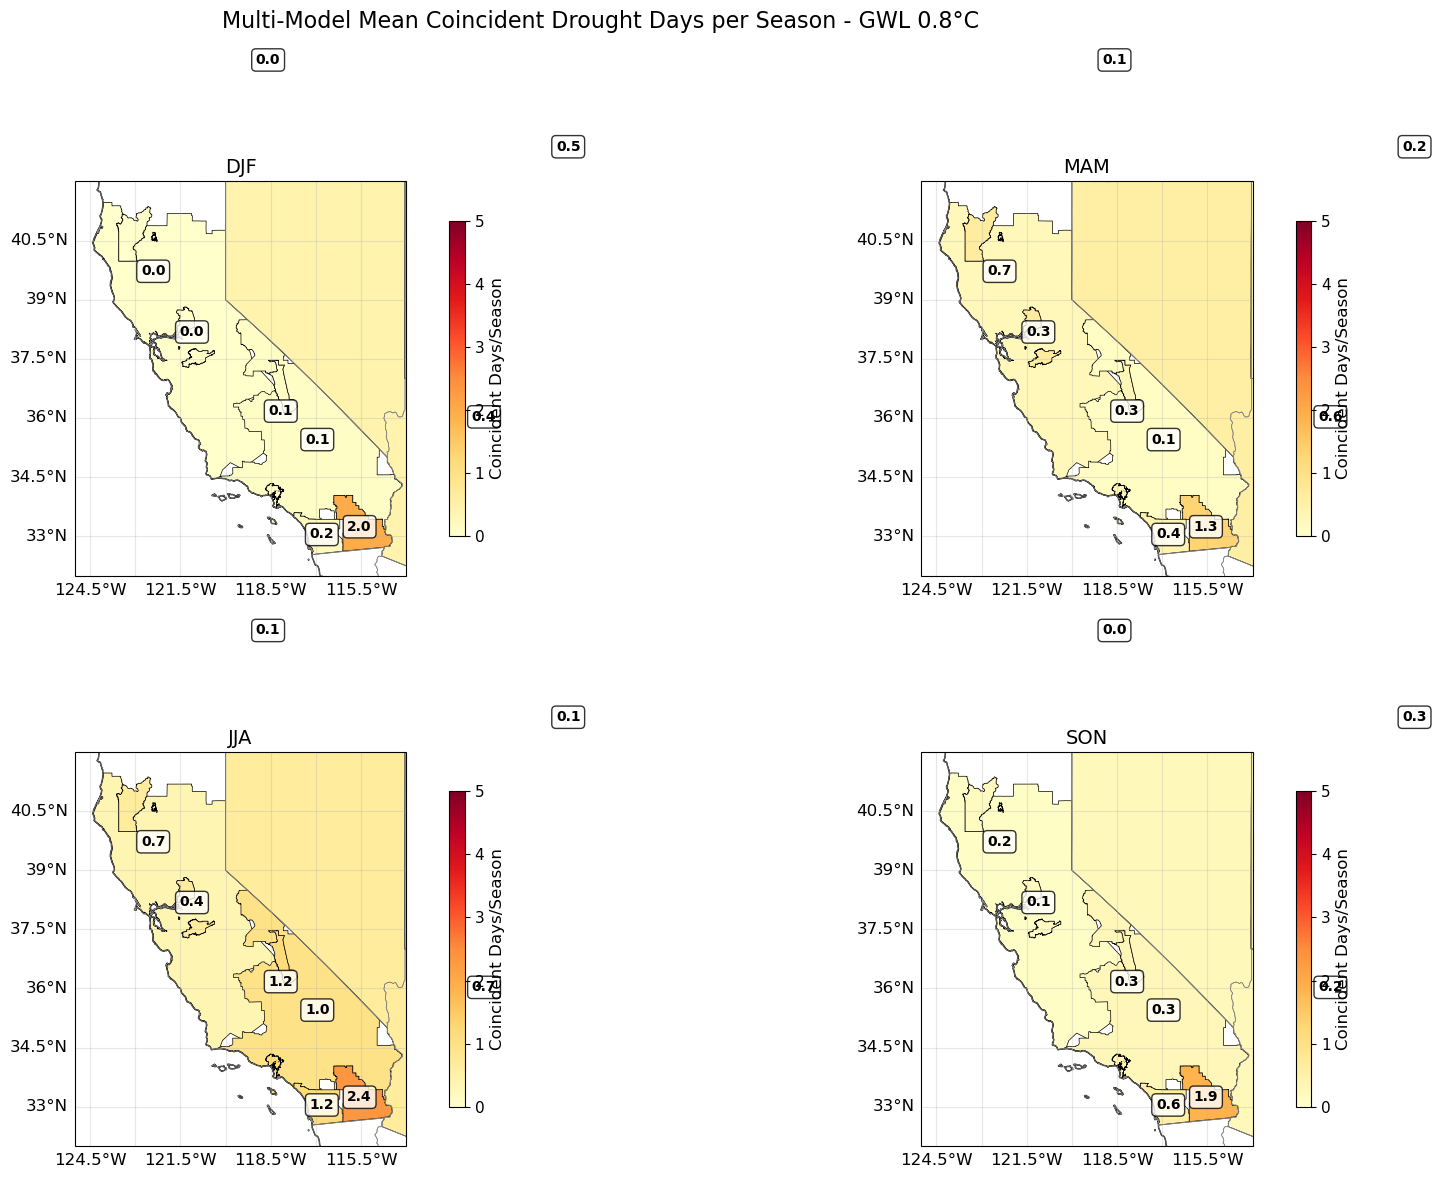

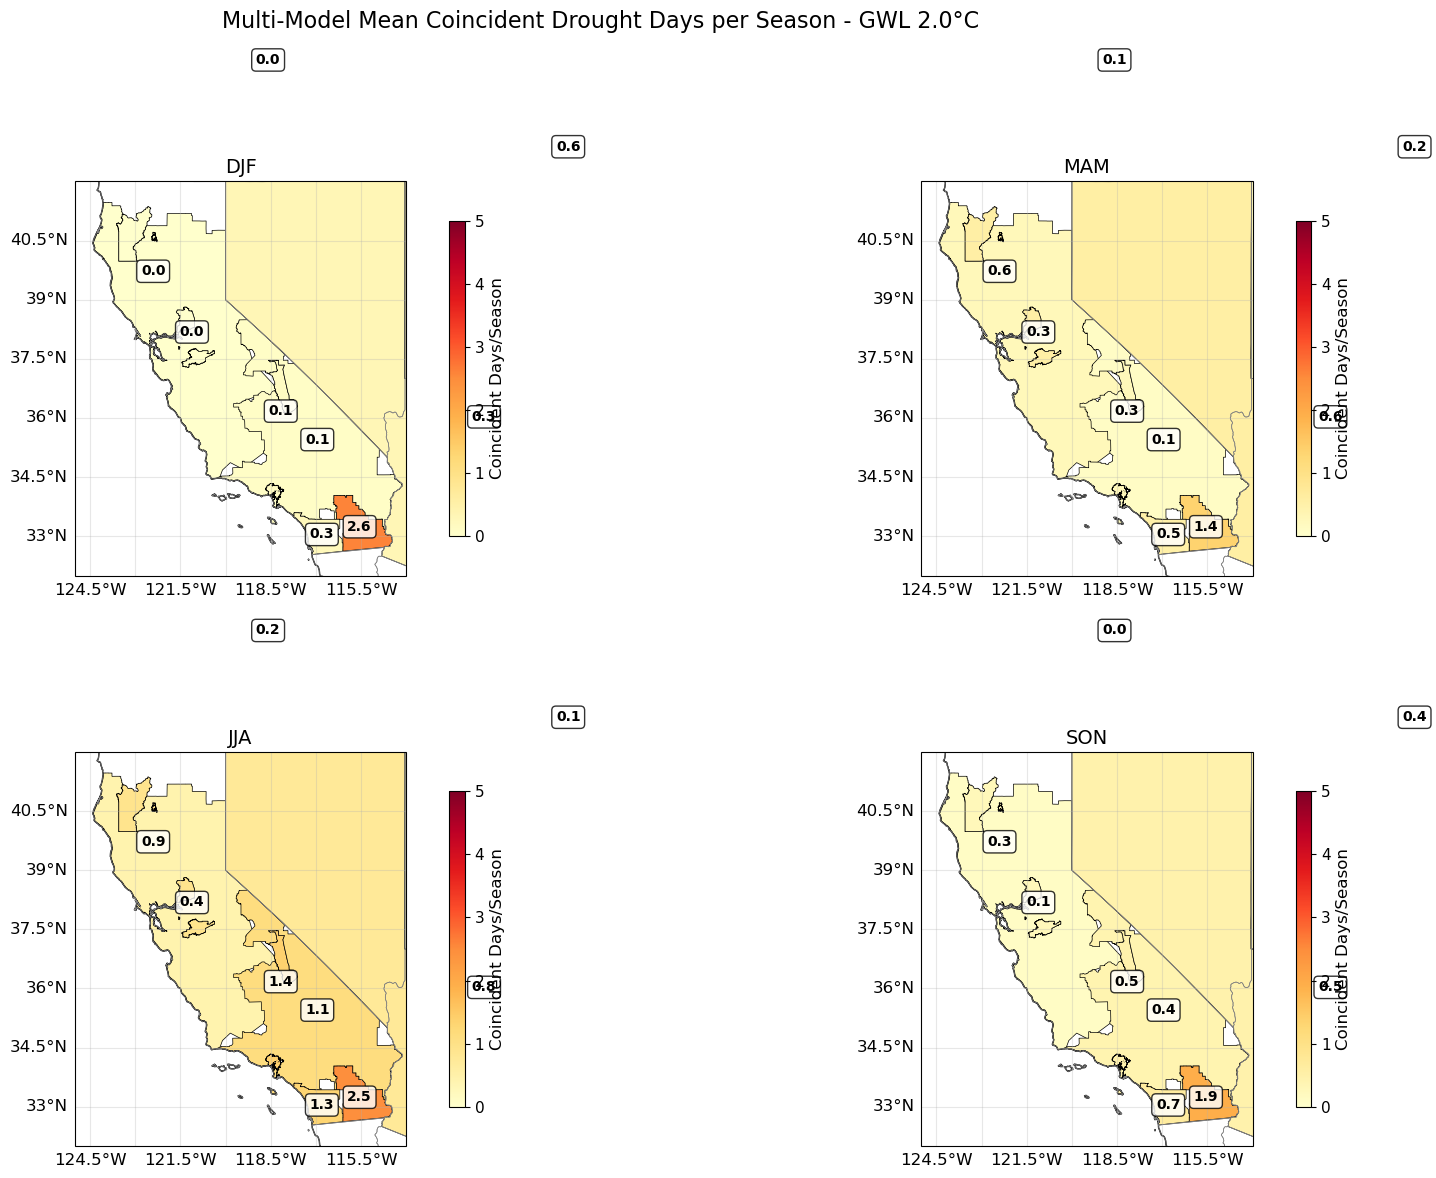

In [16]:
# Choropleth maps: Multi-model mean for both GWLs, 4 seasons per GWL
for gwl in target_gwls:
    fig, axes = plt.subplots(2, 2, figsize=(18, 12), subplot_kw={'projection': ccrs.PlateCarree()})
    axes = axes.flatten()
    
    for idx, season in enumerate(seasons):
        ax = axes[idx]
        
        # Get multi-model mean data for this GWL and season
        data = ensemble_data[(ensemble_data['gwl'] == gwl) & (ensemble_data['season'] == season)].set_index('region')
        
        # Merge with shapefile
        gdf_plot = gdf.copy()
        gdf_plot['coincident_days'] = gdf_plot['name'].map(
            lambda x: data.loc[x, 'coincident_days_per_season'] if x in data.index else np.nan
        )
        
        # Plot
        gdf_plot.plot(
            column='coincident_days',
            ax=ax,
            cmap='YlOrRd',
            edgecolor='black',
            linewidth=0.5,
            legend=True,
            vmin=0,
            vmax=5,
            legend_kwds={'label': 'Coincident Days/Season', 'shrink': 0.8}
        )
        
        # Add region labels
        for idx_region, row in gdf_plot.iterrows():
            if pd.notna(row['coincident_days']):
                centroid = row.geometry.centroid
                ax.text(
                    centroid.x, centroid.y, 
                    f"{row['coincident_days']:.1f}",
                    ha='center', va='center', 
                    fontsize=10, fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8)
                )
        
        # Formatting
        ax.coastlines()
        ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor='gray')
        ax.set_title(f'{season}', fontsize=14)
        ax.set_extent([-125, -114, 32, 42])  # California bounds
        
        # Add gridlines
        gl = ax.gridlines(draw_labels=True, alpha=0.3)
        gl.top_labels = False
        gl.right_labels = False
    
    fig.suptitle(f'Multi-Model Mean Coincident Drought Days per Season - GWL {gwl}°C', fontsize=16, y=0.98)
    plt.tight_layout()
    plt.savefig(f'choropleth_seasonal_multimodel_gwl{gwl}.png', dpi=300, bbox_inches='tight')
    plt.show()

## Figure 8: Choropleth Maps - Change in Coincident Drought by Season

Visualize the spatial pattern of changes between GWL 0.8°C and 2.0°C for each season.

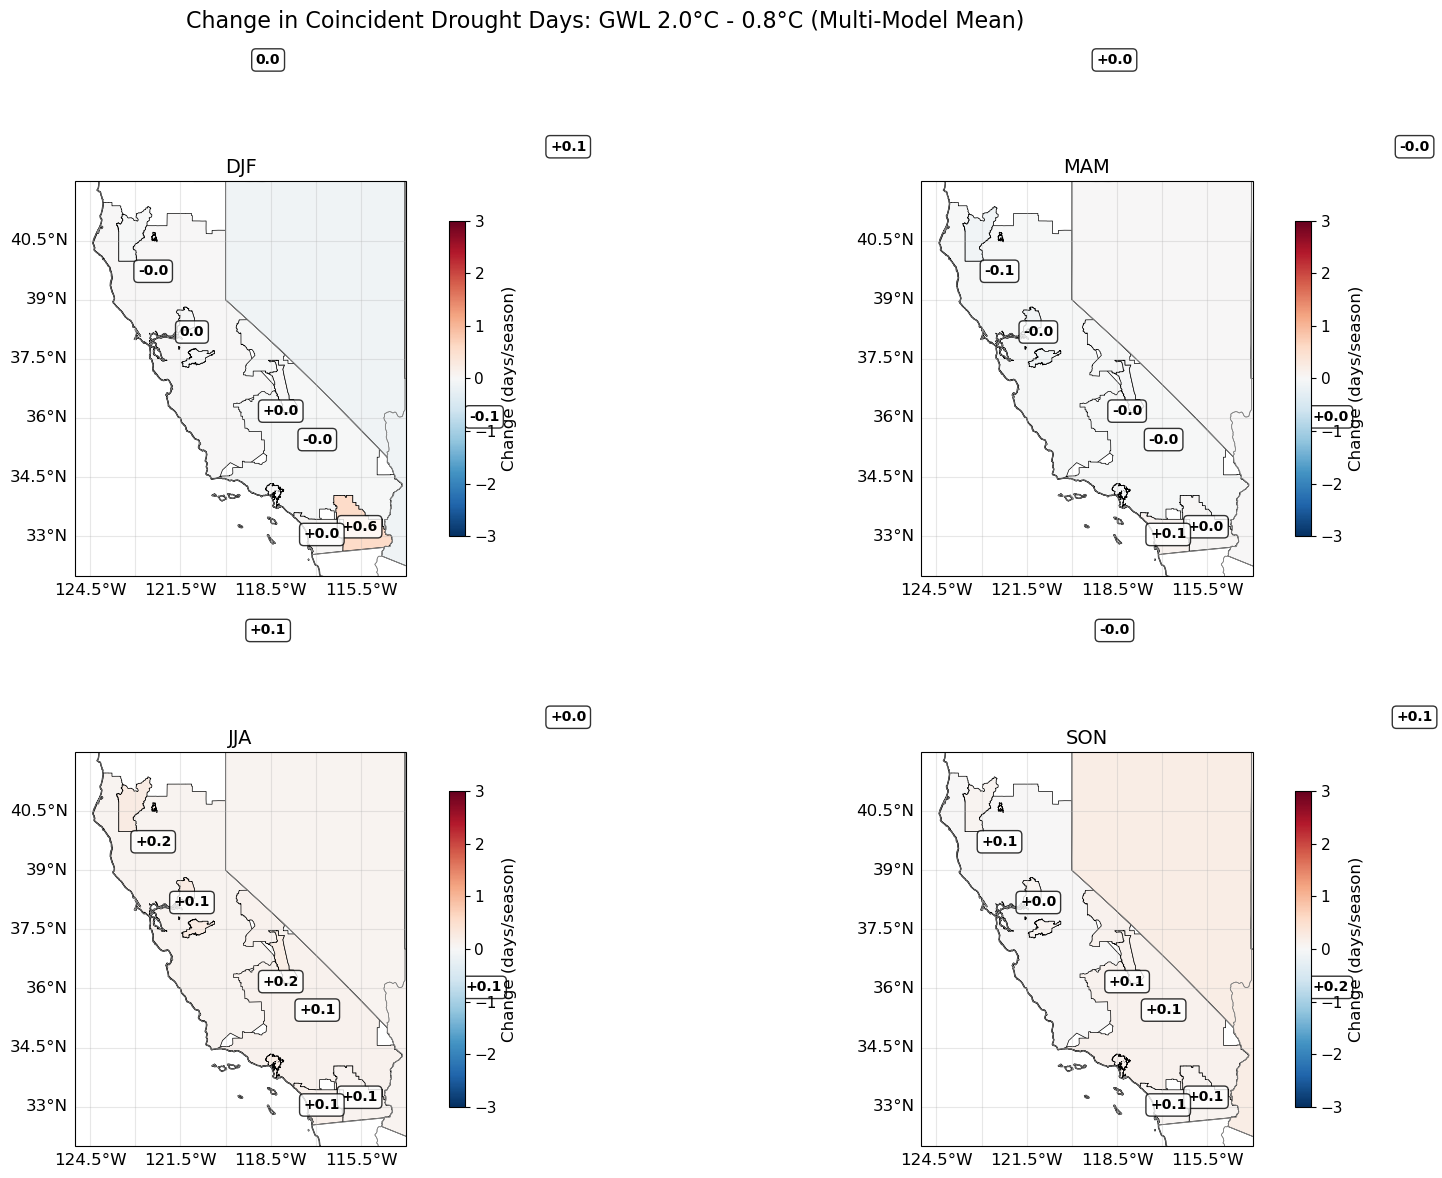

In [17]:
# Choropleth maps showing absolute change (GWL 2.0 - 0.8) by season
fig, axes = plt.subplots(2, 2, figsize=(18, 12), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()

for idx, season in enumerate(seasons):
    ax = axes[idx]
    
    # Get change data for this season
    season_change = ensemble_change[ensemble_change['season'] == season].set_index('region')
    
    # Merge with shapefile
    gdf_plot = gdf.copy()
    gdf_plot['change'] = gdf_plot['name'].map(
        lambda x: season_change.loc[x, 'change'] if x in season_change.index else np.nan
    )
    
    # Plot
    gdf_plot.plot(
        column='change',
        ax=ax,
        cmap='RdBu_r',
        edgecolor='black',
        linewidth=0.5,
        legend=True,
        vmin=-3,
        vmax=3,
        legend_kwds={'label': 'Change (days/season)', 'shrink': 0.8}
    )
    
    # Add region labels with change values
    for idx_region, row in gdf_plot.iterrows():
        if pd.notna(row['change']):
            centroid = row.geometry.centroid
            sign = '+' if row['change'] > 0 else ''
            ax.text(
                centroid.x, centroid.y, 
                f"{sign}{row['change']:.1f}",
                ha='center', va='center', 
                fontsize=10, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8)
            )
    
    # Formatting
    ax.coastlines()
    ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor='gray')
    ax.set_title(f'{season}', fontsize=14)
    ax.set_extent([-125, -114, 32, 42])  # California bounds
    
    # Add gridlines
    gl = ax.gridlines(draw_labels=True, alpha=0.3)
    gl.top_labels = False
    gl.right_labels = False

fig.suptitle('Change in Coincident Drought Days: GWL 2.0°C - 0.8°C (Multi-Model Mean)', 
             fontsize=16, y=0.98)
plt.tight_layout()
plt.savefig('choropleth_seasonal_change_absolute.png', dpi=300, bbox_inches='tight')
plt.show()

In [20]:
gdf_plot

,name,states,num_states,geometry,pct_change
0,PG&E,None,NaN,"POLYGON ((-119.26048 35.76148, -119.25829 35.7...",18.181818
1,IID,None,NaN,"POLYGON ((-116.40553 34.03287, -116.40481 34.0...",4.035874
2,LDWP,None,NaN,"MULTIPOLYGON (((-118.26968 33.73704, -118.2697...",38.461538
3,NCNC,None,NaN,"MULTIPOLYGON (((-120.39563 37.70604, -120.3953...",39.130435
4,SCE,None,NaN,"MULTIPOLYGON (((-118.60397 33.47807, -118.6038...",48.484848
5,SDG&E,None,NaN,"MULTIPOLYGON (((-117.23297 32.77509, -117.2329...",9.859155
6,WECC_NW,"ID, OR, WA",3.0,"MULTIPOLYGON (((-116.75723 48.99994, -116.4175...",-50.000000
7,WECC_SW,"AZ, NM, NV",3.0,"POLYGON ((-108.62031 36.99929, -108.3793 36.99...",89.655172
8,WECC_MTN,"CO, MT, UT, WY",4.0,"POLYGON ((-114.72705 49.00059, -114.67822 49.0...",41.176471


In [21]:
CA_regions = ["PG&E", "IID", "SCE", "SDG&E", "LDWP", "NCNC"]

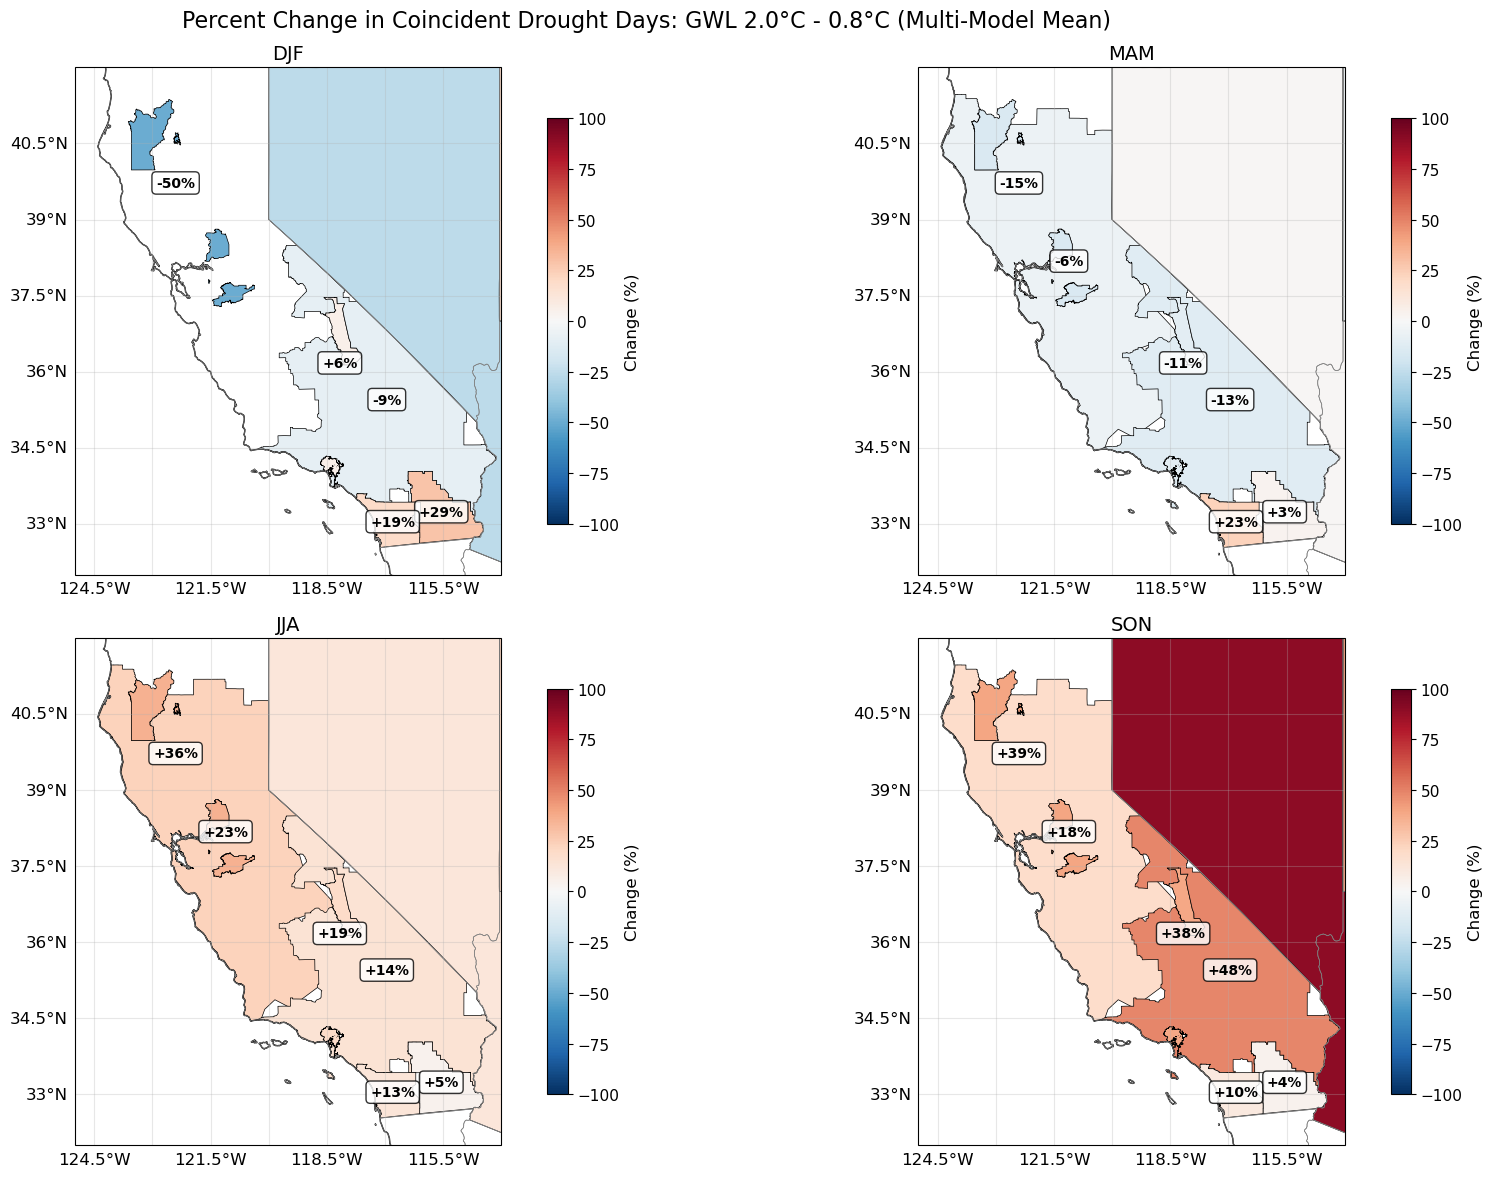

In [22]:
# Choropleth maps showing percent change (GWL 2.0 - 0.8) by season
fig, axes = plt.subplots(2, 2, figsize=(18, 12), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()

for idx, season in enumerate(seasons):
    ax = axes[idx]
    
    # Get percent change data for this season
    season_change = ensemble_change[ensemble_change['season'] == season].set_index('region')
    
    # Merge with shapefile
    gdf_plot = gdf.copy()
    gdf_plot['pct_change'] = gdf_plot['name'].map(
        lambda x: season_change.loc[x, 'pct_change'] if x in season_change.index else np.nan
    )
    
    # Plot
    gdf_plot.plot(
        column='pct_change',
        ax=ax,
        cmap='RdBu_r',
        edgecolor='black',
        linewidth=0.5,
        legend=True,
        vmin=-100,
        vmax=100,
        legend_kwds={'label': 'Change (%)', 'shrink': 0.8}
    )
    
    # Add region labels with percent change values
    for idx_region, row in gdf_plot.iterrows():
        if row['name'] in CA_regions and pd.notna(row['pct_change']):
            centroid = row.geometry.centroid
            sign = '+' if row['pct_change'] > 0 else ''
            ax.text(
                centroid.x, centroid.y, 
                f"{sign}{row['pct_change']:.0f}%",
                ha='center', va='center', 
                fontsize=10, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8)
            )
    
    # Formatting
    ax.coastlines()
    ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor='gray')
    ax.set_title(f'{season}', fontsize=14)
    ax.set_extent([-125, -114, 32, 42])  # California bounds
    
    # Add gridlines
    gl = ax.gridlines(draw_labels=True, alpha=0.3)
    gl.top_labels = False
    gl.right_labels = False

fig.suptitle('Percent Change in Coincident Drought Days: GWL 2.0°C - 0.8°C (Multi-Model Mean)', 
             fontsize=16, y=0.98)
plt.tight_layout()
plt.savefig('choropleth_seasonal_change_percent.png', dpi=300, bbox_inches='tight')
plt.show()